# Projet final : Combustion du méthane dans une configuration à contre courant ###

# Introduction
L'objectif de ce projet est de simuler la combustion du méthane dans l'air dans une configuration à contre courant. Le méthane et l'air sont injectés l'un en face de l'autre, dans une direction opposée, et de l'azote est injecté de la même façon en haut et en bas de la boite de simulation pour diluer et protéger les deux autres gaz des variations extérieures. La simulation se fait dans une boîte de 2 mm sur 2 mm avec une paroi glissante à gauche, un bord ouvert à droite et deux murs non glissants en haut et en bas en dehors des zones d'injection.

La simulation de ce phénomène va se faire en plusieurs étapes pour être bien certain que chaque calcul soit correct. Pour commencer, l'objectif sera de résoudre les équations de Navier-Stokes avec une méthode par pas fractionnés d'ordre 1 afin de déterminer les composantes u et v (respectivement selon x et y) de la vitesse tout au long de la réaction. Une fois la vitesse déterminée, nous pourront alors en déduire le taux de déformation $a$ défini comme $a = dv/dy$ sur le bord gauche (donc le mur glissant) exclusivement. Le taux de déformation est très utile pour analyser plus en détail les intéraction fluides-parois, comme par exemple déterminer le régime de l'écoulement ou les forces de cisaillements qui s'exercent.

Dans un second temps, l'objectif sera de simuler uniquement le transport des particules d'azote. En effet, celles ci étant spectatrices dans la réaction de combustion, elles ne sont que transportées et ne sont pas appauvries. Elles n'influencent pas non plus la température, ce qui signifie qu'une fois les composantes des vitesses calculées, nous pouvons directement simuler le transport de ces particules. L'objectif final sera de déterminer la zone diffusive de l'azote sur le bord gauche de la boîte de simulation. L'intérêt de connaitre cette zone est de pouvoir par la suite étudier les profils de concentrations ou bien encore d'améliorer et d'optimiser des procédés (dans notre cas, optimiser la combustion par exemple).

Enfin, le but final sera de simuler le transport global de toutes les espèces intervenant dans la réaction chimique et ainsi pouvoir déterminer l'évolution de la température en fonction du temps lors de la réaction. Il sera finalement possible de déterminer quelle est la température maximale atteinte lors de la combustion. En se basant sur les données disponibles sur internet, lors d'une combustion dite idéale comme cette que nous simulons, la température maximale devrait se trouver entre 1700 et 2500 K.

# Partie 1 : Calcul des composantes de la vitesse

### 1 - La théorie : Les équations de Navier-Stokes et les méthodes par pas fractionnés

L'intérêt de cette partie est donc de calculer les composantes de la vitesse pour chaque temps donné afin d'avoir une idée du déplacement des particules (et par la suite de pouvoir résoudre leurs équations de transport). Pour cela, nous allons résoudres les équations de Navier-Stokes qui s'écrivent :

\begin{align}
     \frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} + v \frac{\partial u}{\partial y} &= -\frac{1}{\rho}\frac{\partial P}{\partial x} + \nu (\frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}) \\
     \frac{\partial v}{\partial t} + u \frac{\partial v}{\partial x} + v \frac{\partial v}{\partial y} &= -\frac{1}{\rho}\frac{\partial P}{\partial y} + \nu (\frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2})\\
     \frac{\partial u}{\partial x} + \frac{\partial v}{\partial y} & = 0
\end{align}

Avec $\rho = 1.1614 kg/m^3$ la densité du fluide, $\nu = 15e-6 m^2/s$ la viscosité cinématique et $P$ la pression. Pour résoudre ce système d'équation, nous allons utiliser une méthode par pas fractionnés. Cela signifie que pour calculer une vitesse au temps $t+1$ nous allons d'abord calculer une vitesse intermédiaire sans le terme de pression appelée $u^*$ puis nous allons résoudre l'équation de Poisson pour trouver la pression grâce à cette vitesse intermédiaire. Finalement, notre vitesse au temps $t+1$ se calculera comme la somme du gradient de pression et de la vitesse intermédiaire. On associe à la composante x l'indice i, à la composante y l'indice j et au temps l'indice n. On écrit la vitesse intermédiaire comme : 

\begin{equation}
    u^{*}_{i,j} = u^{n}_{i,j} - \frac{dt}{2dx} (u^{n}_{i,j} \times (u^{n}_{i+1,j} - u^{n}_{i-1,j}) + v^{n}_{i,j} \times (u^{n}_{i,j+1} - u^{n}_{i,j-1})) + \nu  \frac{dt}{dx^2}  (u^{n}_{i-1,j} - 4 u^{n}_{i,j} + u^{n}_{i+1,j} + u^{n}_{i,j-1} +u^{n}_{i,j+1})
\end{equation}

Cette discrétisation est la même pour $v^*$. Une fois que la vitesse intermédiaire est calculée, nous pouvons calculer la pression. On rappelle l'équation de Poisson :

\begin{equation} 
    \Delta P = \frac{\rho}{dt} \times (\frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y})
\end{equation}

L'équation de Poisson peut donc être résolue en résolvant une équation de la forme $Ap = b$ avec A la matrice associée au Laplacien et b le second membre, ici $1/dt \times (\frac{\partial u^*}{\partial x} + \frac{\partial v^*}{\partial y})$. Une fois la pression résolue, on peut écrire finalement :

\begin{align}
    & u^{n+1}_{i,j} = u^{*}_{i,j} - \frac{dt}{2dx} \times \frac{1}{\rho} \times (\frac{\partial P}{\partial x}) \\
    & v^{n+1}_{i,j} = v^{*}_{i,j} - \frac{dt}{2dx} \times \frac{1}{\rho} \times (\frac{\partial P}{\partial y}) 
\end{align}

### 2 - Le code et la simulation

In [3]:
#Importation des bibliothèques utiles
import numpy as np
from numba import jit
import matplotlib.pyplot as plt

In [4]:
#Definition des constantes du problème 
#On convertit toutes les valeurs en système SI
Lx = 0.002 #m 
Nx = 50 
dx = Lx/(Nx - 1)
Nt = 500
Tf = 0.01#s
dt = Tf/(Nt - 1)
nu = 15e-6 #m^2/s
D = 15e-6 #m^2/s
a = 15e-6 #m^2/s
rho = 1.1614 #kg/m^3
cp = 1200 #J/kg.K

In [5]:
#Verification si Tf permet d'arriver en régime stationnaire
def verif_Tf_regime_stationnaire(Nx, Lx, Tf):
    # Temps nécessaire pour traverser la boîte à chaque vitesse
    
    t1 = Lx / 1  # Temps pour la vitesse rapide
    t2 = Lx*(1 - 1/4) / 0.2  # Temps pour la vitesse lente
    
    # Vérification si Tf est supérieur au temps de traversée pour la vitesse lente
    if Tf >= t2:
        return f"Le régime stationnaire peut être atteint."
    else:
        
        return f"Le régime stationnaire ne peut pas être atteint."

print(verif_Tf_regime_stationnaire(Nx,Lx, Tf))

Le régime stationnaire peut être atteint.


In [6]:
#Verification de la condition CFL
def CFL(dx, dt, nu):
    #CFL diffusion 
    dt_diff = dx**2 * 0.5 / nu
    
    #CFL advection 
    dt_adv = min(dx*0.5, 0.5*dx/0.2)
    
    # Vérification
    CFL = dt <= min(dt_diff, dt_adv) 
    print(f" Pas de temps : {dt:.6f}")
    print(f" Pas d'espace : {dx:.6f}")
    return f"La condition CFL est ({CFL})."

print(CFL(dx,dt,nu))

 Pas de temps : 0.000020
 Pas d'espace : 0.000041
La condition CFL est (True).


Je considère un indice unique k définit comme k = i + j$\times$Nx pour avoir des données cohérentes dans tous nos tableaux. Nos vitesses u,v et notre pression p ne sont donc pas des matrices 2D Nx sur Nx à chaque pas de temps mais bien des vecteurs de dimension Nx^2. Cela me permet de ne pas me mélanger avec le fait que i et j en python sont associés respectivement à y et x et non pas l'inverse. Tous les vecteurs sont donc dimensionnés en Nx^2 et la matrice du laplacien A est dimensionnée en (Nx^2, Nx^2)

Par exemple, le vecteur vitesse selon x est donc ainsi organisé:

$\mathbf{U} = \left( u_{0,0}, u_{1,0}, \ldots, u_{n,0}, u_{0,1}, \ldots, u_{i,j}, u_{i+1,j}, \ldots \right)^T
$

In [7]:
#Définition de la matrice de vitesse V (selon y) à l'instant t=0
#x = i , y = j
# Définition de l'indice k qui permet d'avoir des coordonnées cohérentes dans tous nos tableaux (parce que je m'emmêle avec le fait que x = j et y = i sur python)
def k(i,j):
    return i + j*Nx

#Définition du vecteur v0, le vecteur correspondant à la vitesse v (selon y) à t=0
def V0_cond(Nx):
    V0 = np.zeros((Nx*Nx))
    for i in range(Nx):  # x devient l'indice des lignes
        for j in range(Nx):  # y devient l'indice des colonnes
            if j == 0 : # bord bas 
                if 0 <= i < Nx//4:
                    V0[k(i,j)] = 1
                if  Nx//4 <= i < Nx//2:
                    V0[k(i,j)] = 0.2
            if j == Nx-1: # bord haut 
                if 0 <= i < Nx//4:
                    V0[k(i,j)] = -1
                if  Nx//4 <= i < Nx//2:
                    V0[k(i,j)] = -0.2
    return V0


# Fonction pour calculer u* (dx = dy). 
def u_etoile(u0, v0, dx, dt, Nx):
    ustar, vstar = np.empty((Nx*Nx)), np.empty((Nx*Nx))
    u, v = np.empty((Nx*Nx)), np.empty((Nx*Nx))
    un, vn = u0.copy(), v0.copy()
    mu = dt / (2*dx)
    mu2 = dt / dx**2
    for i in range(Nx):
        for j in range(Nx):
        #prise en compte des conditions de bord
            if i == 0: #bord gauche
                u[k(i,j)] = u0[k(i,j)]
                v[k(i,j)] = v0[k(i,j)]
            elif i == Nx-1: #bord droit
                u[k(i,j)] = u0[k(i,j)]
                v[k(i,j)] = v0[k(i,j)]
            elif j == 0: #bord bas
                u[k(i,j)] = u0[k(i,j)]
                v[k(i,j)] = v0[k(i,j)]
            elif j == Nx-1: #bord haut
                u[k(i,j)] = u0[k(i,j)]
                v[k(i,j)] = v0[k(i,j)]
            else:
                u[k(i,j)] = un[k(i,j)] - mu * (un[k(i,j)] * (un[k(i+1,j)] - un[k(i-1,j)]) + (vn[k(i,j)] * (un[k(i,j+1)] - un[k(i,j-1)]))) + nu * mu2 * ((un[k(i+1,j)] - 2*un[k(i,j)] + un[k(i-1,j)]) + un[k(i,j+1)] - 2*un[k(i,j)] + un[k(i,j-1)])
                v[k(i,j)] = vn[k(i,j)] - mu * (un[k(i,j)] * (vn[k(i+1,j)] - vn[k(i-1,j)]) + (vn[k(i,j)] * (vn[k(i,j+1)] - vn[k(i,j-1)]))) + nu * mu2 * ((vn[k(i+1,j)] - 2*vn[k(i,j)] + vn[k(i-1,j)]) + vn[k(i,j+1)] - 2*vn[k(i,j)] + vn[k(i,j-1)])
    return u, v
    
# Définition de la matrice A pour résoudre Ap = b   
def A_matrix(Nx,dx):
    N = Nx**2
    A = np.zeros((N,N))
    for i in range(Nx):
        for j in range(Nx):
            if i == 0: #bord gauche
                A[k(i,j),k(i,j)] = -1/dx
                A[k(i,j),k(i,j)+1]= 1/dx
            elif i == Nx-1: #bord droit
                A[k(i,j),k(i,j)] = 1
            elif j == 0: #bord bas
                A[k(i,j),k(i,j)] = -1/dx
                A[k(i,j),k(i,j)+Nx] = 1/dx
            elif j == Nx-1: #bord haut
                A[k(i,j),k(i,j)] = 1/dx
                A[k(i,j),k(i,j)-Nx] = -1/dx
            else: #intérieur de la matrice
                A[k(i,j),k(i,j)] = -4/dx**2
                A[k(i,j),k(i,j)-1] = 1/dx**2
                A[k(i,j),k(i,j)+1] = 1/dx**2
                A[k(i,j),k(i,j)+Nx] = 1/dx**2
                A[k(i,j),k(i,j)-Nx] = 1/dx**2
    return A
    
#Définition du second membre     
def b_secondmember(u_star,v_star,Nx,dx):
    b = np.zeros(Nx*Nx)
    mu = 1/(2*dx*dt)
    for i in range(Nx):
        for j in range(Nx):
            if i == 0:  # Bord gauche
                b[k(i,j)] = 0
            elif i == Nx-1:  # Bord droit
                b[k(i,j)] = 0
            elif j == 0:  # Bord bas
                b[k(i,j)] = 0  
            elif j == Nx-1:  # Bord haut
                b[k(i,j)] = 0
            else:
                b[k(i,j)] = mu * ((u_star[k(i+1,j)] - u_star[k(i-1,j)]) + (v_star[k(i,j+1)] - v_star[k(i,j-1)]))
    return b

def Poisson_direct(A,b):
    x = np.linalg.solve(A, b)
    return x


#Définition des conditions initiales sur V, U et P
U0 = np.zeros((Nx*Nx))
V0 = V0_cond(Nx)
P0 = np.zeros((Nx*Nx))

# Simulation par pas fractionnés (x = j, i = y)
def fractional_step(u0, v0, p0, dt, dx, nu, Nt, Nx, rho):
    u, v, p = np.zeros((Nx*Nx, Nt)), np.zeros((Nx*Nx, Nt)), np.zeros((Nx*Nx, Nt)) #Création de tableaux pour stocker les valeurs
    u[:, 0], v[:, 0],p[:,0] = U0.copy(), V0.copy(), P0.copy() # Conditions initiales
    mu = dt/(2*dx)
    A = A_matrix(Nx,dx)
    r = np.zeros(Nt)
    print("Conditionnement de la matrice =", round(np.linalg.cond(A), 0))
    for n in range(1,Nt):
        u_star, v_star = u_etoile(u[:, n-1], v[:, n-1], dx, dt, Nx)
        b = b_secondmember(u_star,v_star,Nx,dx)
        p[:, n] = Poisson_direct(A,b)
        r[n] = (np.linalg.norm(b - A @ p[:,n], 2)/np.linalg.norm(b, 2)) #2 = norme euclidienne
        for i in range(1,Nx-1):
            for j in range(1,Nx-1):
                u[k(i,j), n] = u_star[k(i,j)] - mu / rho * (p[k(i+1,j), n] - p[k(i-1,j), n])
                v[k(i,j), n] = v_star[k(i,j)] - mu / rho * (p[k(i,j+1), n] - p[k(i,j-1), n])
        for i in range(Nx):
            for j in range(Nx):
            #Conditions de bord
                if i == 0: #bord gauche
                    u[k(i,j), n] = 0  # 
                    v[k(i,j), n] = v[k(i+1,j),n]
                elif i == Nx-1: #bord droit
                    u[k(i,j),n] = u[k(i,j-1),n]
                    v[k(i,j),n] = v[k(i,j-1),n]
                elif j == 0: #bord bas
                    u[k(i,j),n] = 0
                    v[k(i,j),n] = 0
                    if 0 <= i < Nx//4:
                        v[k(i,j)] = 1
                    if  Nx//4 <= i < Nx//2:
                        v[k(i,j)] = 0.2
                elif j == Nx-1: #bord haut
                    u[k(i,j),n] = 0
                    v[k(i,j),n] = 0
                    if 0 <= i < Nx//4:
                        v[k(i,j)] = -1
                    if  Nx//4 <= i < Nx//2:
                        v[k(i,j)] = -0.2
    print("Le résidu moyen est =", round(np.mean(r),16))
    return p,u,v, 

#Résultats associés
p, u, v  = fractional_step(U0, V0, P0, dt, dx, nu, Nt, Nx, rho)

Conditionnement de la matrice = 34608001438.0
Le résidu moyen est = 1.05e-14


Le conditionnement d'une matrice permet de connaitre sa sensibilité aux erreurs. Ici, A est très mal conditionnée car sa valeur est très éloignée de 1, elle est donc susceptible de modifier grandement le vecteur p s'il y a une toute petite erreur en entrée. C'est d'ailleurs pour cela que la méthode de résolution directe par numpy est la plus appropriée, car les méthode par convergence ne fonctionnent qu'après un très grand nombre d'itérations voir même divergent à cause de ce conditionnement. Il est possible d'appliquer un préconditionnement à la matrice pour baisser son conditionnement (comme un gradient conjugué) mais cela demande un peu plus de puissance de calcul, ce que je n'ai pas vraiment. La solution directe par la fonction linalg.solve permet d'obtenir un résidu moyen relatif de 1e-14 ce qui est très satisfaisant et qui montre que la manière de calculer ce résultat est performant pour notre cas.

On va maintenant se servir de la variation de pression pour déterminer à partir de quel point le régime stationnaire est atteint. Pour cela, on regarde lorsque la variation de pression entre un instant $n$ et un instant $n+1$ est inférieur à 1e-8. C'est une valeur arbitraire mais suffisament petite pour considérer que la stationnarité est atteinte.

In [8]:
#Détermination du point à partir du quel on consdière que le régime stationnaire est atteint
def temps_stationnaire(Nx,Nt,p, epsilon = 1e-6):
    #On initialise la somme sur p à Nx*Nx pour être sur qu'elle soit grande
    Ysum = Nx*Nx
    for n in range(1,Nt):
        Ysum_courant = np.sum(p[:,n]) #La somme de toutes les valeurs de p à l'instant n
        Ydiff = abs(Ysum_courant - Ysum) / Ysum_courant #Calcul de la différence entre la somme à l'instant n et celle à n-1 que l'on normalise par la somme à l'instant n
        Ysum = Ysum_courant #la somme à l'instant n-1 devient celle à l'instant n
        if Ydiff < epsilon: #Si la différence est inférieure à 1e-6 on arrête la boucle et on renvoit les valeurs
            Nstat = n
            tstat = n*dt
            return Nstat, tstat
        
Nstat, tstat = temps_stationnaire(Nx,Nt,p, epsilon = 1e-8)
print("Le temps stationnaire est atteint pour t =", round(tstat,4),"s pour l'itération",Nstat)

Le temps stationnaire est atteint pour t = 0.0084 s pour l'itération 417


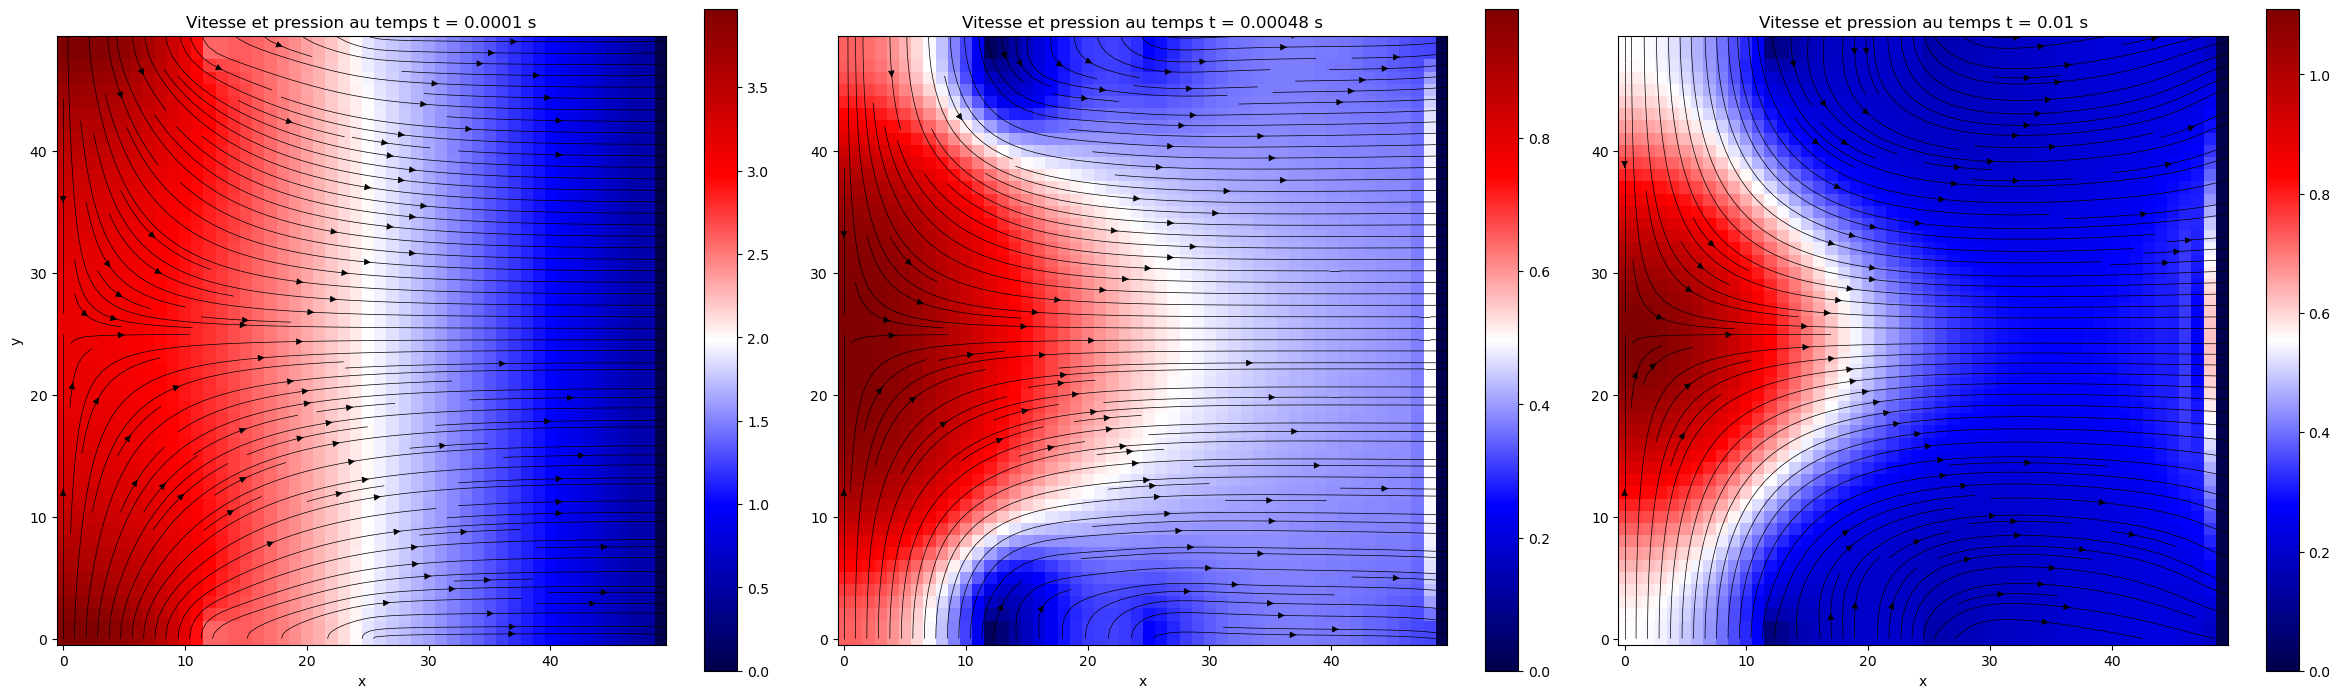

In [9]:
#Evolution de la vitesse et de la pression 

x = np.linspace(0, Nx, Nx)  
y = np.linspace(0, Nx, Nx)  
X, Y = np.meshgrid(x, y)  

fig, axs1 = plt.subplots(1, 3, figsize=(24, 7))  

im11 = axs1[0].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,5], np.reshape(v,(Nx,Nx,Nt))[:,:,5], color='black', density = 1.8, linewidth = 0.5, cmap = None)
c = axs1[0].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,5], cmap='seismic', origin='lower', interpolation='nearest')
axs1[0].set_title(f"Vitesse et pression au temps t = {5*dt:.4f} s")
axs1[0].set_xlabel("x")
axs1[0].set_ylabel("y")
fig.colorbar(c, ax=axs1[0])

im12 = axs1[1].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,(Nt-1)//20], np.reshape(v,(Nx,Nx,Nt))[:,:,(Nt-1)//20], color='black', density = 1.8, linewidth = 0.5, cmap = None)
d = axs1[1].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,(Nt-1)//20], cmap='seismic', origin='lower', interpolation='nearest')
axs1[1].set_title(f"Vitesse et pression au temps t = {dt*((Nt-1)//20):.5f} s")
axs1[1].set_xlabel("x")
fig.colorbar(d, ax=axs1[1])

im13 = axs1[2].streamplot(x, y, np.reshape(u,(Nx,Nx,Nt))[:,:,(Nt-1)], np.reshape(v,(Nx,Nx,Nt))[:,:,(Nt-1)], color='black', density = 1.8, linewidth = 0.5, cmap = None)
e = axs1[2].imshow(np.reshape(p,(Nx,Nx,Nt))[:,:,(Nt-1)], cmap='seismic', origin='lower', interpolation='nearest')
axs1[2].set_title(f"Vitesse et pression au temps t = {dt*(Nt-1):} s")
axs1[2].set_xlabel("x")
fig.colorbar(e, ax=axs1[2])


plt.tight_layout()  
plt.show()



On observe qu'au temps intermédiaire et final il semble il y avoir une légère surpression à la sortie du fluide (sur le bord droit). Cela est du au fait que l'on impose une condition de Dirichlet sur ce bord et que l'on définit la pression comme nulle. Pour s'approche d'un modèle physique un peu plus réalise et pour éviter l'apparition de cette légère surpression, il est préférable d'avoir une condition de Neumann sur ce bord écrit comme $dP/dx = 0$ car cela permet à la pression de s'écouler sans être "bloquée" par ce mur. Cela n'a pas grand importance ici car nos vitesses s'écoulent tout de même normalement sur le bord droit.

Le coefficient de déformation maximal absolu est 24500.0 s^-1 et a une position sur le bord gauche y = 0.0 m
Le coefficient de déformation en stationnaire est 1491.21 s^-1 et a une position y = 0.001 m


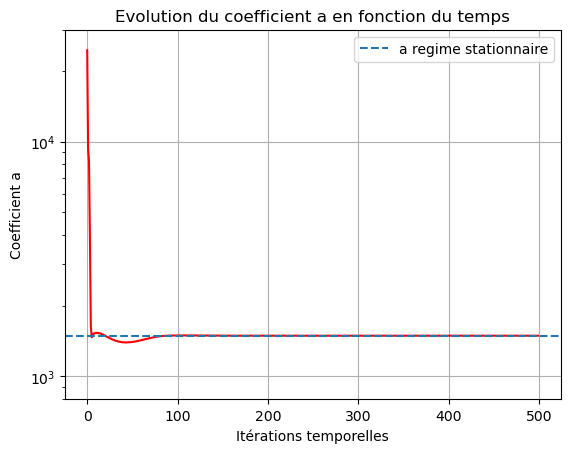

In [10]:
#Question 1
dv_dy = np.zeros((Nx,Nt))  # Initialisation de dv/dy 
# Calcul de dv/dy pour chaque pas de temps
for t in range(Nt):
    for j in range(Nx):
        if j == 0:  #Coin bas
            dv_dy[j,t] = abs((v[k(0,j+1), t] - v[k(0,j),t]) / dx)
        elif j == Nx - 1 :#Coin haut
            dv_dy[j,t] = abs((v[k(0,j), t] - v[k(0,j-1),t]) / dx)
        else:
            dv_dy[j,t] = abs((v[k(0,j+1),t] - v[k(0,j-1),t]) / (2*dx))

#evolution temporelle de a
dv_dy_max = np.zeros(Nt)
for n in range(Nt):
    dv_dy_max[n] = np.max(dv_dy[:,n])


#Plot du coefficient en fonction du temps
plt.plot(dv_dy_max, "r")
plt.yscale("log")
plt.ylim(800,30000)
plt.grid(True)
plt.xlabel("Itérations temporelles")
plt.ylabel("Coefficient a")
plt.axhline(y = np.max(dv_dy[:,Nstat]), linestyle = "--", label = "a regime stationnaire")
plt.title("Evolution du coefficient a en fonction du temps")
plt.legend(loc = "upper right")

#Trouver les indices correspondants à la valeur maximale de dv/dy en espace et en temps
indices_max = np.unravel_index(np.argmax(dv_dy), dv_dy.shape)
indices_max_stat = np.unravel_index(np.argmax(dv_dy[:,Nstat]), dv_dy[:,Nstat].shape)
print("Le coefficient de déformation maximal absolu est", round(np.max(dv_dy),2),"s^-1 et a une position sur le bord gauche y =",indices_max[1]*dx,"m")
print("Le coefficient de déformation en stationnaire est", round(np.max(dv_dy[:,Nstat]),2),"s^-1 et a une position y =",round(indices_max_stat[0]*dx,4),"m")

Les valeurs moyennes pour les coefficients de déformation le long d'une paroi se trouvent entre $10^2$ et $10^5 s^{-1}$ en général, ce qui nous permet de penser que notre coefficient rentre parfaitement dans cet ordre de grandeur. Il est plus grand au niveau des coins haut et bas à gauche tout simplement parce que la vitesse est la plus grande à ces instants et qu'elle est purement selon y. Cela parait donc logique d'avoir le coefficient le plus grand dans ces coins. On a également vu que les vitesses sont quasiment nulles à la moitié du mur gauche, ce qui montre d'autant plus que le gradient de vitesse est plus grand dans les coins.

# Partie 2 : Le transport de YN2

### La théorie : L'équation de transport

L'azote n'est ici présent que pour diluer les gaz chauds. En réalité, la combustion du méthane ne se fait qu'avec l'oxygène présent dans l'injection d'air. On considère ici de l'air pur composé à 79% de N2 et à 21% d'O2. On négligera toute impuretée. La réaction chimique de la combustion s'écrit :

\begin{equation}
CH_4 + 2O_2 \longrightarrow CO_2 + 2H_2 O
\end{equation}

Le gaz N2 est donc bien spectateur dans la réaction. Celui ci ne subit donc pas d'effets de température ni d'appauvrissement, mais est seulement transporté par l'équation suivante :

\begin{equation}
\frac{\partial Y_{N2}}{\partial t} + u\times \frac{\partial Y_{N2}}{\partial x} + v\times \frac{\partial Y_{N2}}{\partial y} = D \times (\frac{\partial^2 Y_{N2}}{\partial x^2} + \frac{\partial^2 Y_{N2}}{\partial y^2})
\end{equation}

Avec D = $\nu$  la diffusion massique du fluide. Le but de cette partie va donc être de résoudre cette équation pour N2. Pour cela, on discrétise en espace les dérivées exactement comme pour la vitesse. On centre les discrétisation.


On commence par implémenter les conditions initiales de YN2 avant de se lancer dans la résolution de l'équation

In [11]:
#Conditions initiales de N2
def YN2_0(Nx):
    Y0 = np.zeros((Nx*Nx))
    for i in range(Nx):  # x devient l'indice des lignes
        for j in range(Nx):  # y devient l'indice des colonnes
            if j == 0 : # bord bas 
                if 0 <= i < Nx//4:
                    Y0[k(i,j)] = 0.79
                if  Nx//4 <= i < Nx//2:
                    Y0[k(i,j)] = 1
            if j == Nx-1: # bord haut 
                if  Nx//4 <= i < Nx//2:
                    Y0[k(i,j)] = 1
    return Y0

In [14]:
#Calcul de YN2. YN2 n'est pas influencé par la température car est spectateur dans la réaction
def calcul_YN2(u,v,YN2_0, dt, dx, D, Nt, Nx, rho):
    #Constantes d'équation
    mu = dt/(2*dx)
    mu2 = dt/dx**2
    
    #Tableau de stockage
    YN2_f = np.zeros((Nx*Nx,4))
    t = np.zeros(4)
    
    #Interval de temps 
    interval = [0,30, 100, Nt-1]
    
    #Conditions initiales
    YN2 = YN2_0(Nx).copy()
    YN2_f[:,0] = YN2_0(Nx).copy()
    t[0] = 0
    
    #Calcul des points intérieurs pour YN2 pour chaque pas de temps
    for n in range(1,Nt):
        for i in range(1, Nx-1):
            for j in range(1, Nx-1):
                YN2[k(i,j)] = YN2[k(i,j)] - mu * (u[k(i,j),n-1] * (YN2[k(i+1,j)] - YN2[k(i-1,j)]) + v[k(i,j),n-1] * (YN2[k(i,j+1)] -YN2[k(i,j-1)])) + mu2 *D * (YN2[k(i+1,j)] - 4*YN2[k(i,j)] + YN2[k(i-1,j)] + YN2[k(i,j+1)]  + YN2[k(i,j-1)])
                +mu2 *(u[k(i,j),n-1]**2) * ( YN2[k(i+1,j)] - 2*YN2[k(i,j)] +YN2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YN2[k(i,j+1)] + YN2[k(i,j-1)] - 2*YN2[k(i,j)] )
        #Conditions de bord
        for i in range(Nx):
            YN2[k(i,0)] = YN2[k(i,1)]
            YN2[k(i,Nx-1)] = YN2[k(i,Nx-2)]
            if 0 <= i < Nx//4:
                YN2[k(i,0)] = 0.79
            elif  Nx//4 <= i < Nx//2:
                YN2[k(i,0)] = 1
                YN2[k(i,Nx-1)] = 1
        for j in range(Nx):
            YN2[k(0,j)] = YN2[k(1,j)]
            YN2[k(Nx-1,j)] = YN2[k(Nx-2,j)]
        if n in interval:
            index = interval.index(n)
            YN2_f[:,index] = YN2
            t[index] = n*dt
    return YN2_f, t 

YN2_calc, temps = calcul_YN2(u,v,YN2_0, dt, dx, D, Nt, Nx, rho)

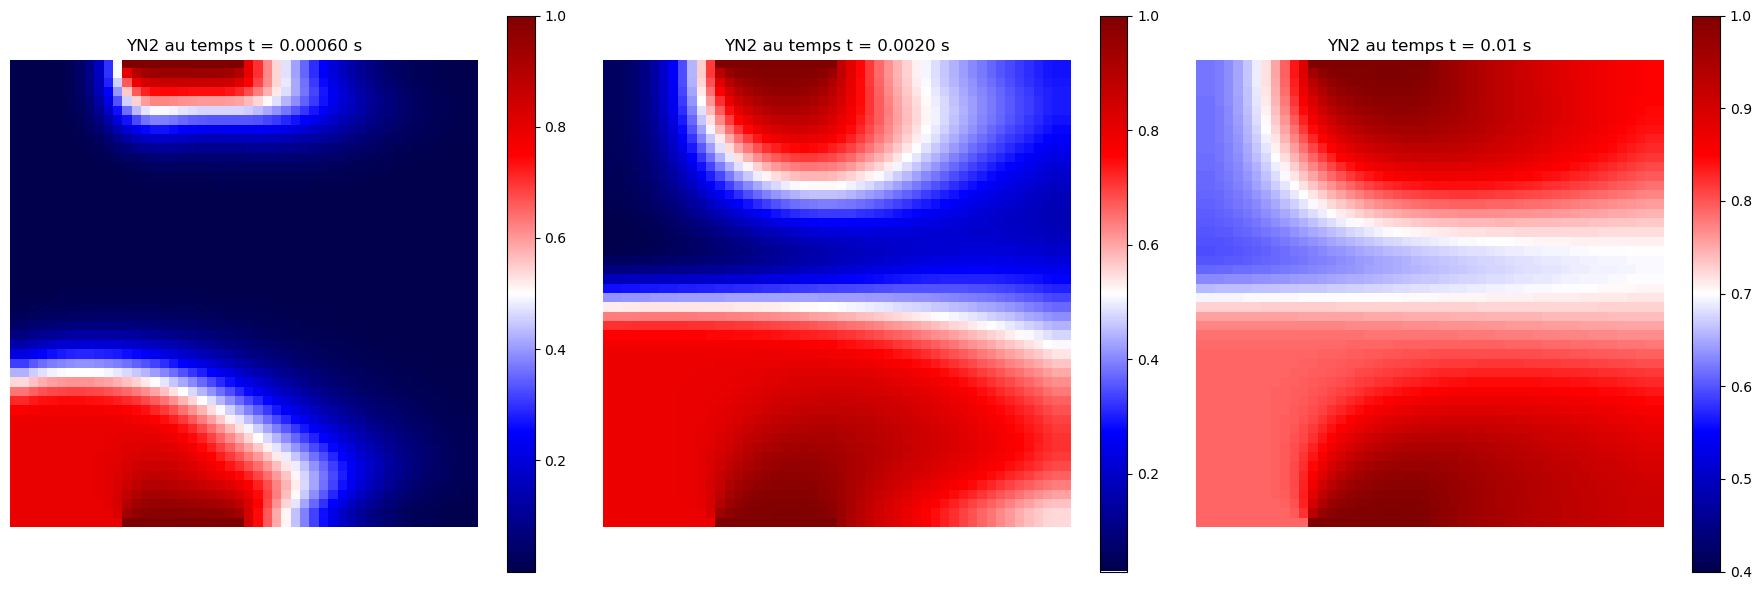

In [15]:
#Evolution de YN2 dans le temps
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im12 = axs2[0].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs2[0].set_title(f"YN2 au temps t = {temps[1]:.5f} s")
axs2[0].invert_yaxis()
axs2[0].axis('off')  # Masquer les axes
fig2.colorbar(im12, ax=axs2[0])

im21 = axs2[1].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs2[1].set_title(f"YN2 au temps t = {temps[2]:.4f} s")
axs2[1].invert_yaxis()
axs2[1].axis('off')  # Masquer les axes
fig2.colorbar(im21, ax=axs2[1])

im32 = axs2[2].imshow(np.reshape(YN2_calc,(Nx,Nx,4))[:,:,3], cmap='seismic', vmin=0.4, vmax=1)
axs2[2].set_title(f"YN2 au temps t = {temps[3]:} s")
axs2[2].invert_yaxis()
axs2[2].axis('off')  
fig2.colorbar(im32, ax=axs2[2])

plt.tight_layout()  
plt.show()


On remarque bien l'évolution asymétrique de YN2 par rapport à la ligne médiane horizontale de la boite. Cela s'explique par l'injection de l'air seulement par le bas de la boite. On observe bien la zone de diffusion sur le bord gauche. On réccupère les données le long de ce mur et on se place au dernier pas de temps pour être sûrs d'être en régime stationnaire pour tracer l'épaisseur de cette zone de diffusion. 

In [16]:
#Question 2
Bord_bas = round(0.1*0.79,4)
Bord_haut = round(0.9*0.79,4)

#épaisseur mur gauche
epaisseur = np.reshape(YN2_calc,(Nx,Nx,4)).copy()
epaisseur[(epaisseur < Bord_bas) | (epaisseur > Bord_haut)] = 0 
epaisseur[(epaisseur > Bord_bas) & (epaisseur < Bord_haut)] = 1
epaisseur_gauche = epaisseur[:,0,3]
ep = np.sum(epaisseur_gauche)*dx

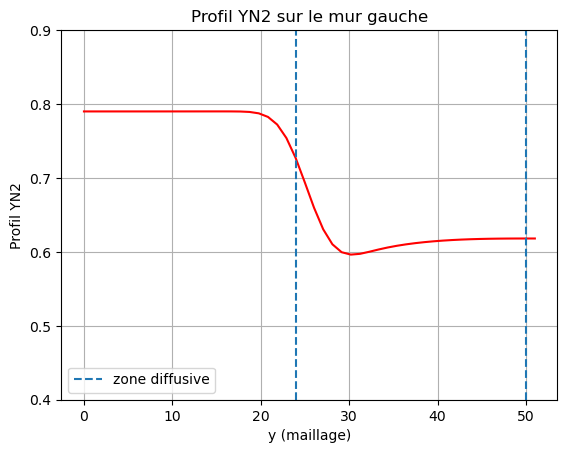

L'épaisseur de la zone diffusive sur le bord gauche est de 0.0011 m


In [17]:
YN2_mod = np.reshape(YN2_calc,(Nx,Nx,4))
YN2_gauche = YN2_mod[:,0,3]
h = np.linspace(0,Nx+1,Nx)

#Print du profil de YN2 sur le mur gauche
plt.plot(h,YN2_gauche,'r') #Je considère le dernier temps pour être sûre d'être en régime stationnaire.
plt.grid(True)
plt.xlabel("y (maillage)")
plt.ylim(0.4,0.9)
plt.axvline(x = Nx - ep/dx, linestyle = "--", label = "zone diffusive")
plt.axvline(x = Nx, linestyle = "--")
plt.ylabel("Profil YN2")
plt.title("Profil YN2 sur le mur gauche")
plt.legend(loc = "lower left")
plt.show()
print("L'épaisseur de la zone diffusive sur le bord gauche est de",round(ep,4),"m")

La zone diffusive sur le bord gauche a une forme de tangeante hyperbolique en régime stationnaire. On remarque que pour les y proches de 0, la concentration est à 0.79, c'est à dire à la valeur d'injection, tandis que pour les y proches du haut de la boite, la concentration est beaucoup plus basse (environ 0.5) et est liée à la diffusion de l'injection de N2 en haut. On remarque donc que là où le N2 est directement injecté contre le bord, il n'y a pas vraiment de diffusion puisque toutes les particules se déplacent vers la droite. Autrement, on aurait pu constater une augmentation de la concentration ce qui n'est pas le cas. La diffusion est beaucoup plus claire en haut de la boite ou ce sont les particules de N2 non injectées sur le bord gauche qui se diffusent vers celui ci. La zone de décroissance que l'on observe est la zone de transition entre la zone haute de diffusion et la zone basse d'injection. L'épaisseur de la zone diffusive est : 0.0011 m.

# Partie 3 : La simulation globale de toutes les espèces et de la température 

### La théorie : Les équations de transport

L'objectif de cette partie est de simuler le transport et l'appauvrissement des 4 espèces intervenant dans l'équation de la combustion : CH4, O2, H2O et CO2. Pour cela, l'objectif est de résoudre l'équation suivante pour chaque espèce :

\begin{equation}
\frac{\partial Y_{k}}{\partial t} + u\times \frac{\partial Y_{k}}{\partial x} + v\times \frac{\partial Y_{k}}{\partial y} = D \times (\frac{\partial^2 Y_{k}}{\partial x^2} + \frac{\partial^2 Y_{k}}{\partial y^2}) + \frac{\dot \omega_k}{\rho}
\end{equation} 

Avec k l'espèce concernée et $\dot \omega_k$ le taux de réaction défini comme $\dot \omega = W_k \nu_k Q$. $W_k$ est la masse molaire de chaque espèce, $\nu_k$ le coefficient stoechiométrique molaire et $Q$ le taux de progression de la réaction. $Q$ est défini par :

\begin{equation} 
Q = A[CH4][O2]^2e^{-Ta/T}
\end{equation}

Avec Ta la température d'activation fixée à 10000K et A = 1.1e8. L'équation de transport pour chaque espèce est associée à l'equation de transport de la température, ce qui nous donne le système suivant à résoudre :

\begin{align}
& \frac{\partial Y_{k}}{\partial t} + u\times \frac{\partial Y_{k}}{\partial x} + v\times \frac{\partial Y_{k}}{\partial y} = D \times (\frac{\partial^2 Y_{k}}{\partial x^2} + \frac{\partial^2 Y_{k}}{\partial y^2}) + \frac{\dot \omega_k}{\rho}\\
&\frac{\partial T}{\partial t} + u\times \frac{\partial T}{\partial x} + v\times \frac{\partial T}{\partial y} = a \times (\frac{\partial^2 T}{\partial x^2} + \frac{\partial^2 T}{\partial y^2}) + \frac{\dot \omega_T}{\rho c_p}
\end{align}

Avec $\dot \omega_T$ le dégagement de chaleur, qui s'exprime comme : $\dot \omega_T = - \sum_k^Ns \frac{\Delta h_{f,k}^0}{W_k} \dot \omega_k$ avec $\Delta h_{f,k}^0$ l'enthalpie de formation de chaque espèce k et D = a = $\nu$. 

On commence par définir les condition initiales pour chaque espèce k (N2 exclu). On considère qu'il n'y a pas de H2O ni de CO2 au début de la simulation donc leurs fractions molaires sont égales à 0 partout dans la boîte de simulation.

In [24]:
#Conditions initiales pour toutes les espèces (hors YN2)
def Yk_0(Nx, espece = "CH4"):
    Y0 = np.zeros((Nx*Nx))
    if espece == "CH4":
        for i in range(Nx):  # x devient l'indice des lignes
            if  0 <= i < Nx//4:
                Y0[k(i,Nx-1)] = 1
        return Y0
    elif espece == "O2":
        for i in range(Nx):  # x devient l'indice des lignes
            if  0 <= i < Nx//4:
                Y0[k(i,0)] = 0.21
        return Y0
    else:
        return Y0

Pour avoir une meilleure visibilité du transport pur de chacune des espèces, j'implémente un solveur pour pouvoir visualiser le transport de CH4 et de O2 sans la température

In [26]:
#Transport de Y sans T ni appauvrissement (pour avoir une idée de la diffusion et de l'advection sur les particules )
def Yk_calc_sans_T(u,v, Yk_0, dt, dx, D, Nt, Nx, rho, espece = "N2"):
    Yk_f = np.zeros((Nx**2,4))
    t = np.zeros(4)
    mu = dt/(2*dx)
    mu2 = dt/dx**2
    intervals = [0,(Nt-1)//10, (Nt-1)//4, (Nt-1)]
    if espece == "CH4":
        Yk = Yk_0.copy()
        Yk_f[:,0] = Yk_0.copy()
        t[0] = 0
        for n in range(1,Nt):
            for i in range(1, Nx-1):
                for j in range(1, Nx-1):
                    Yk[k(i,j)] = Yk[k(i,j)] - mu * (u[k(i,j),n-1] * (Yk[k(i+1,j)] - Yk[k(i-1,j)]) + v[k(i,j),n-1] * (Yk[k(i,j+1)] -Yk[k(i,j-1)])) + mu2 * D * ( Yk[k(i+1,j)] - 4*Yk[k(i,j)] + Yk[k(i-1,j)] + Yk[k(i,j+1)]  + Yk[k(i,j-1)])
                    +mu2 *(u[k(i,j),n-1]**2) * ( Yk[k(i+1,j)] - 2*Yk[k(i,j)] +Yk[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(Yk[k(i,j+1)] + Yk[k(i,j-1)] - 2*Yk[k(i,j)] )
            for i in range(Nx):
                Yk[k(i,0)] = Yk[k(i,1)]
                Yk[k(i,Nx-1)] = Yk[k(i,Nx-2)]
                if  0 <= i < Nx//4:
                    Yk[k(i,Nx-1)] = 1
            for j in range(Nx):
                Yk[k(0,j)] = Yk[k(1,j)]  
                Yk[k(Nx-1,j)] = Yk[k(Nx-2,j)]  
            if n in intervals:
                index = intervals.index(n)
                Yk_f[:,index] = Yk
                t[index] = n*dt
        return Yk_f, t
    elif espece == "O2":
        Yk = Yk_0.copy()
        Yk_f[:,0] = Yk_0.copy()
        t[0] = 0
        for n in range(1,Nt):
            for i in range(1, Nx-1):
                for j in range(1, Nx-1):
                    Yk[k(i,j)] = Yk[k(i,j)] - mu * (u[k(i,j),n-1] * (Yk[k(i+1,j)] - Yk[k(i-1,j)]) + v[k(i,j),n-1] * (Yk[k(i,j+1)] -Yk[k(i,j-1)])) +  mu2 * D * (Yk[k(i+1,j)] - 4*Yk[k(i,j)] + Yk[k(i-1,j)] + Yk[k(i,j+1)]  + Yk[k(i,j-1)])
                    ++mu2 *(u[k(i,j),n-1]**2) * ( Yk[k(i+1,j)] - 2*Yk[k(i,j)] +Yk[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(Yk[k(i,j+1)] + Yk[k(i,j-1)] - 2*Yk[k(i,j)] )
            for i in range(Nx):
                Yk[k(i,0)] = Yk[k(i,1)]
                Yk[k(i,Nx-1)] = Yk[k(i,Nx-2)]
                if 0 <= i < Nx//4:
                    Yk[k(i,0)] = 0.21
            for j in range(Nx):
                Yk[k(0,j)] = Yk[k(1,j)]  
                Yk[k(Nx-1,j)] = Yk[k(Nx-2,j)]  
            if n in intervals:
                index = intervals.index(n)
                Yk_f[:,index] = Yk
                t[index] = n*dt
        return Yk_f, t

YCH4_cal,temps = Yk_calc_sans_T(u,v, Yk_0(Nx, espece = "CH4"), dt, dx, D, Nt, Nx, rho, espece = "CH4")
YO2_cal,temps = Yk_calc_sans_T(u,v, Yk_0(Nx, espece = "O2"), dt, dx, D, Nt, Nx, rho, espece = "O2")

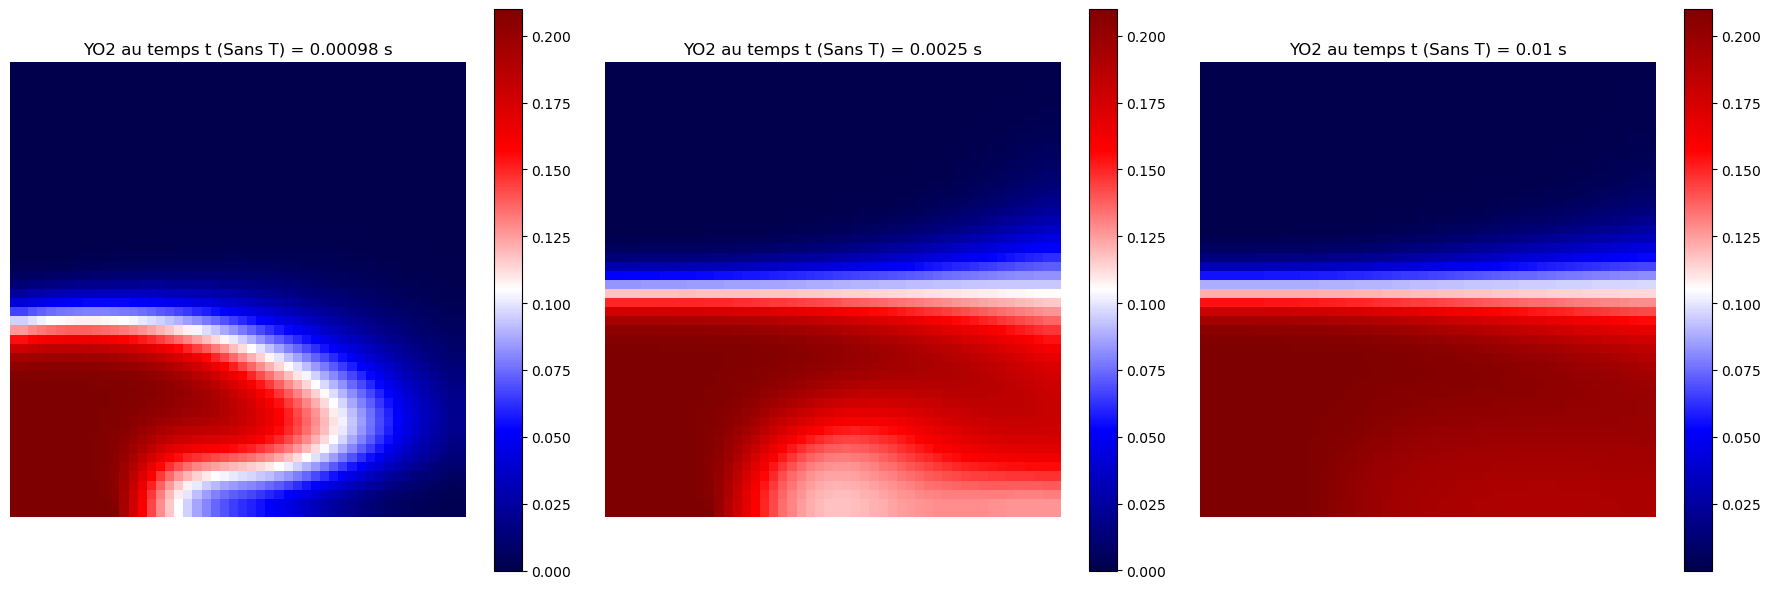

In [27]:
#Evolution de O2 sans prise en compte de la température et sans combustion
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im13 = axs3[0].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs3[0].set_title(f"YO2 au temps t (Sans T) = {temps[1]:.5f} s")
axs3[0].invert_yaxis()
axs3[0].axis('off')  
fig3.colorbar(im13, ax=axs3[0])

# Affichage de la deuxième image
im23 = axs3[1].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs3[1].set_title(f"YO2 au temps t (Sans T) = {temps[2]:.4f} s")
axs3[1].invert_yaxis()
axs3[1].axis('off')  
fig3.colorbar(im23, ax=axs3[1])

# Affichage de la troisième image
im33 = axs3[2].imshow(np.reshape(YO2_cal,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs3[2].set_title(f"YO2 au temps t (Sans T) = {temps[3]:.2f} s")
axs3[2].invert_yaxis()
axs3[2].axis('off')  
fig3.colorbar(im33, ax=axs3[2])

# Afficher la figure
plt.tight_layout()  # Pour ajuster les espaces entre les images
plt.show()

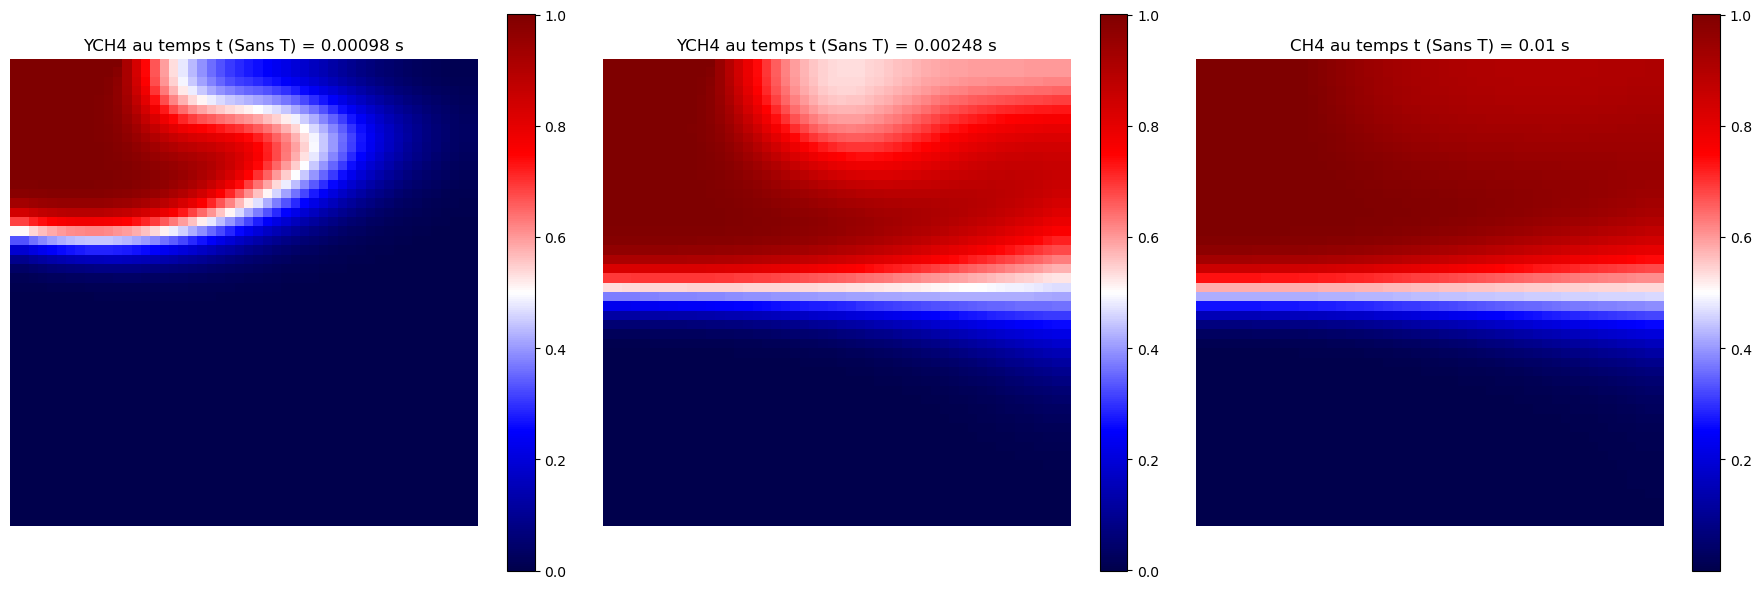

In [28]:
#Evolution de CH4 sans prise en compte de la température et sans combustion
fig3, axs3 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im13 = axs3[0].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs3[0].set_title(f"YCH4 au temps t (Sans T) = {temps[1]:.5f} s")
axs3[0].invert_yaxis()
axs3[0].axis('off')  
fig3.colorbar(im13, ax=axs3[0])

# Affichage de la deuxième image
im23 = axs3[1].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs3[1].set_title(f"YCH4 au temps t (Sans T) = {temps[2]:.5f} s")
axs3[1].invert_yaxis()
axs3[1].axis('off')  
fig3.colorbar(im23, ax=axs3[1])

# Affichage de la troisième image
im33 = axs3[2].imshow(np.reshape(YCH4_cal,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs3[2].set_title(f"CH4 au temps t (Sans T) = {temps[3]:.2f} s")
axs3[2].invert_yaxis()
axs3[2].axis('off')  
fig3.colorbar(im33, ax=axs3[2])

# Afficher la figure
plt.tight_layout()  # Pour ajuster les espaces entre les images
plt.show()

Sans prendre en compte l'impact de la température et donc sans prendre en compte l'appauvrissement, on remarque que le transport de CH4 et de O2 sont symétriques. Cela est attendu car nous résolvons la même équation, simplement pour des conditions initiales différentes. Cela se remarque dans les fractions molaires car celle de CH4 atteint 1 alors que celle de O2 est plafonnée à 0.2.

On passe maintenant à la résolution du système entier, mais on ne considère par le transport de la température pour le moment. Celle ci est fixée à 300 K partout dans la boite sauf sur une bande horizontale centrée de 0.5 mm où la température est constante et vaut 1000 K (pour permettre la combustion). On consdière donc dans un premier temps un réacteur homogène .

In [29]:
#Définition de la température T à t=0 sur toute la grille
def T_0(Nx):
    T0 = np.zeros((Nx*Nx))
    for i in range(Nx):
        for j in range(Nx):
            if 0.00075 <= j*dx < 0.00125:
                T0[k(i,j)] = 1000
            else:
                T0[k(i,j)] = 300
    return T0

Pour déterminer le $\Delta t_{chem}$ adéquat pour notre calcul, je regarde l'ordre de grandeur de $\dot \omega_k$ en prenant celui qui a la possibilité d'être le plus important et je décide que $\Delta t_{chem}$ aura un ordre de grandeur inverse au $\dot \omega_k$ le plus élevé pour être sûre de ne pas avoir de divergence. Pour calculer le $Q_{max}$ possible, je prends les concentration maximales de CH4 et de O2 sur la bande du milieu (là où les espèces se rencontrent) et je les remplace dans la définition des concentration molaire [CH4] et [O2] définies comme $[k] = \rho \frac{Y_k}{W_k}$. Je choisi une température maximale $T_{max}$ arbitraire basée sur les températures atteintes généralement lors de la combustion (ici, pour le réacteur homogène, je prends légèrement au dessus de 1000 K pour être sûre d'avoir un $\Delta t_{chem}$ suffisament petit).

In [30]:
#Calcul pour réacteur homogène 
def reacteur_homogene(u,v, Nx, Tf, Nt, Nstat, dt, cp, rho, D, Tmax):
    #Définition des constantes 
    Ta = 10000
    A = 1.1e8
    
    #Masses molaires
    WCH4 = 16.04e-3
    WO2 = 31.99e-3
    WH2O = 18.01e-3
    WCO2 = 44.00e-3

    #Coefficients stoechiométriques
    nu_CH4 = -1
    nu_O2 = -2
    nu_H2O = 2
    nu_CO2 = 1

    #elthalpie
    HO2 = 0
    HCH4 = -74.9e3
    HH2O = -241.818e3
    HCO2 = -393.52e3

    #Determination de dtchem
    Qmax = A*(rho*0.5/WCH4)*((rho*0.1/WO2)**2)*np.exp(-10000/Tmax)
    dtchem_f = 1e3/(Qmax*44)
    if dtchem_f < dt:
        dtchem = dtchem_f
        Ntchem = int(Tf/dtchem - 1)
        print("Ntchem =", Ntchem)

    else:
        Ntchem = Nt
        dtchem = dt
        print("Ntchem =", Ntchem)
        
    ratio = int((dt // dtchem) + 1)
    dtchem = dt/(ratio) #pour avoir un dtchem exactement multiple de dt
    thydro = np.linspace(0,Tf,Nt)
    tchem = np.linspace(0,Tf,Ntchem)
    print("dthydro = ",dt)
    print("Nthydro=", Nt)
    print("ratio =", ratio)
    print("dtchem =", dtchem)
    interval = [0,(Nt-1)//4, Nstat + 4, Nt-1] #les valeurs de temps que je veux sauver pour mes plots
    mu = dtchem/(2*dx)
    mu2 = dtchem/dx**2
    
    #Définition des tableaux vides
    YCH4_f = np.zeros((Nx*Nx,4))
    YO2_f = np.zeros((Nx*Nx,4))
    YH2O_f = np.zeros((Nx*Nx,4))
    YCO2_f = np.zeros((Nx*Nx,4))
    T_t_f = np.zeros((Nx*Nx,4))
    t = np.zeros(4)

    #Definition des conditions initiales
    YCH40 = Yk_0(Nx, espece = "CH4")
    YO20 = Yk_0(Nx, espece = "O2")
    YH2O0 = Yk_0(Nx, espece = "H2O")
    YCO20 = Yk_0(Nx, espece = "CO2")
    T0 = T_0(Nx)
        
    #Conditions initiales 
    YCH4 = YCH40.copy()
    YO2 = YO20.copy()
    YH2O = YH2O0.copy()
    YCO2 = YCO20.copy()
    T_t = T0.copy()
    YCH4_f[:,0] = YCH40.copy()
    YO2_f[:,0] = YO20.copy()
    YH2O_f[:,0] = YH2O0.copy()
    YCO2_f[:,0] = YCO20.copy()
    t[0] = 0
    
    for n in range(1,Nt):
        for ni in range(ratio):
            for i in range(1,Nx-1):
                for j in range(1,Nx-1):        
                    #Calcul de Q
                    Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                    #Calculs des wk
                    wCH4 = WCH4*nu_CH4*Q
                    wO2 = WO2*nu_O2*Q
                    wCO2 = WCO2*nu_CO2*Q
                    wH2O = WH2O*nu_H2O*Q
                    
                    #Calcul du transport des espèces 
                    YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                    +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                    YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                    +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                    YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                    +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                    YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                    +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                    
                    T_t[k(i,j)] = T_t[k(i,j)]

        
        #Conditions de bord
            for i in range(Nx):
                for j in range(Nx):
                    if i == 0: #bord gauche
                        YCH4[k(i,j)] = YCH4[k(i+1,j)]
                        YO2[k(i,j)] = YO2[k(i+1,j)]
                        YH2O[k(i,j)] = YH2O[k(i+1,j)]
                        YCO2[k(i,j)] = YCO2[k(i+1,j)]
                        T_t[k(i,j)] = T_t[k(i+1,j)]
                    elif i == Nx-1: #bord droit
                        YCH4[k(i,j)] = YCH4[k(i-1,j)]
                        YO2[k(i,j)] = YO2[k(i-1,j)]
                        YH2O[k(i,j)] = YH2O[k(i-1,j)]
                        YCO2[k(i,j)] = YCO2[k(i-1,j)]
                        T_t[k(i,j)] = T_t[k(i-1,j)]
                    elif j == 0: #bord bas
                        YCH4[k(i,j)] = YCH4[k(i,j+1)]
                        YO2[k(i,j)] = YO2[k(i,j+1)]
                        YH2O[k(i,j)] = YH2O[k(i,j+1)]
                        YCO2[k(i,j)] = YCO2[k(i,j+1)]
                        T_t[k(i,j)] = T_t[k(i,j+1)]
                        if  0 <= i < Nx//4:
                            YO2[k(i,j)] = 0.21
                    elif j == Nx-1: #bord haut
                        YCH4[k(i,j)] = YCH4[k(i,j-1)]
                        YO2[k(i,j)] = YO2[k(i,j-1)]
                        YH2O[k(i,j)] = YH2O[k(i,j-1)]
                        YCO2[k(i,j)] = YCO2[k(i,j-1)]
                        T_t[k(i,j)] = T_t[k(i,j-1)]
                        if  0 <= i < Nx//4:
                            YCH4[k(i,j)] = 1
                    if n in interval:
                        index = interval.index(n)
                        YCH4_f[k(i,j),index] = YCH4[k(i,j)]
                        YO2_f[k(i,j),index] = YO2[k(i,j)]
                        YH2O_f[k(i,j),index] = YH2O[k(i,j)]
                        YCO2_f[k(i,j),index] = YCO2[k(i,j)]
                        t[index] = n*dt
                        T_t_f[k(i,j),index] = T_t[k(i,j)]

    return YCH4_f, YO2_f, YH2O_f, YCO2_f, T_t_f, Ntchem, t

YCH4, YO2, YH2O, YCO2, Temp, Ntchem, temps = reacteur_homogene(u,v, Nx, Tf, Nt, Nstat, dt, cp, rho, D, 1000)

Ntchem = 1047
dthydro =  2.0040080160320643e-05
Nthydro= 500
ratio = 3
dtchem = 6.680026720106881e-06


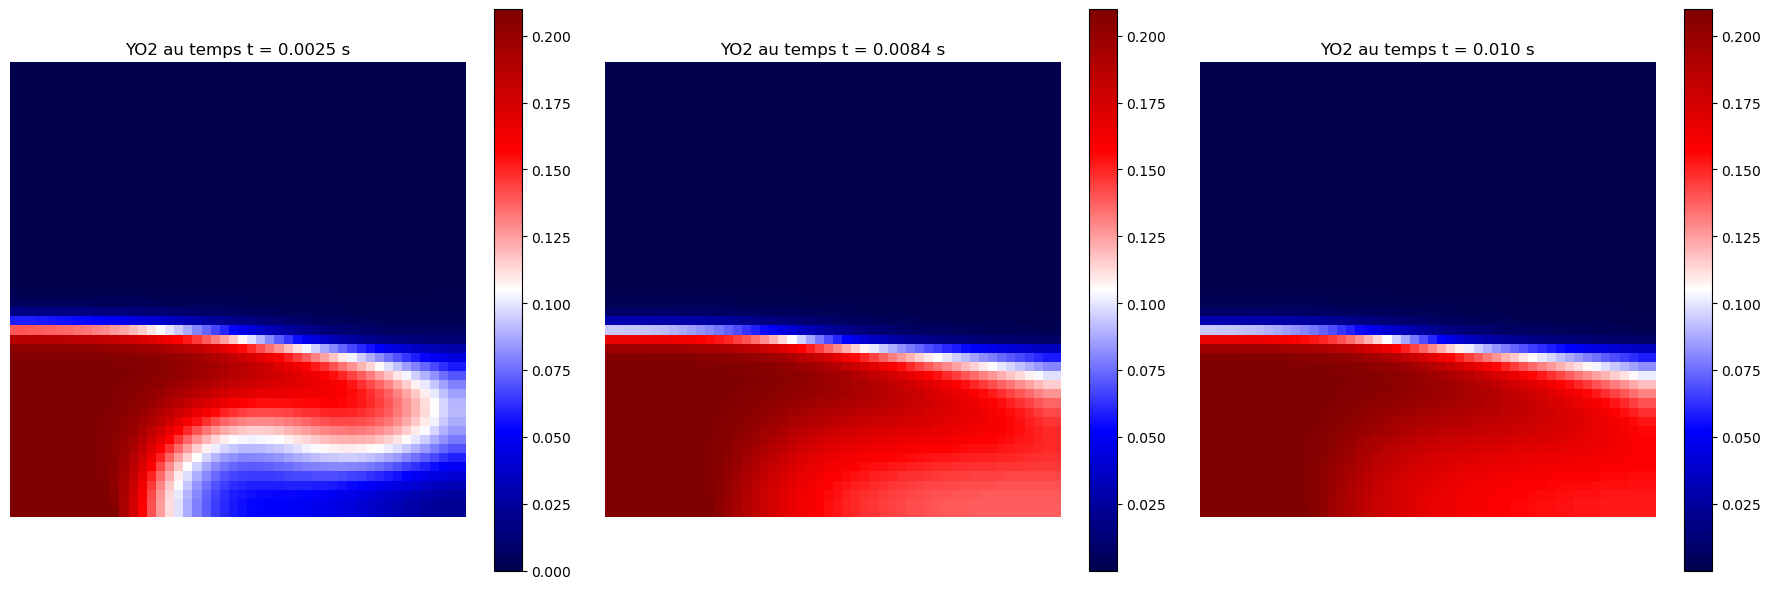

In [32]:
#Evolution de O2 avec prise en compte de la température et avec combustion = Temperature homogène à 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YO2 au temps t = {temps[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YO2 au temps t = {temps[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YO2,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YO2 au temps t = {temps[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

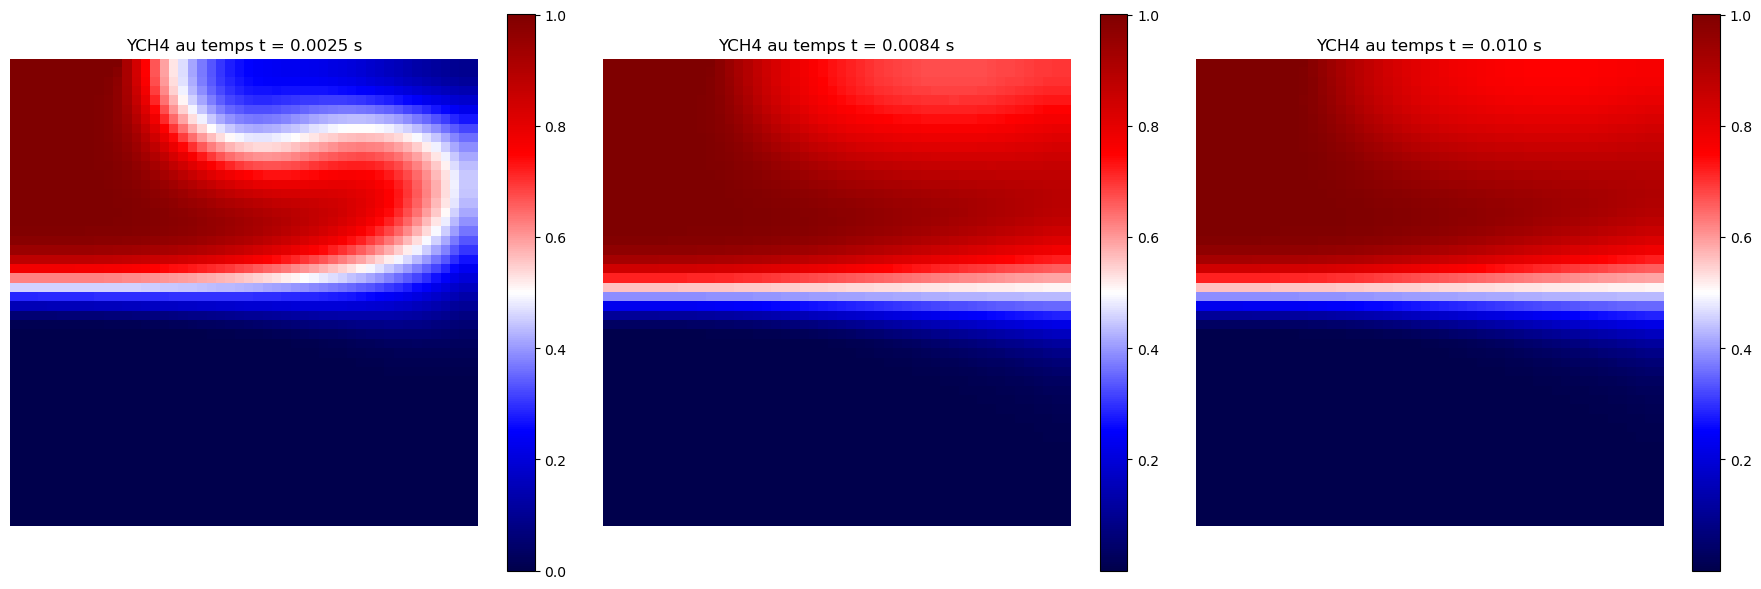

In [33]:
#Evolution de CH4 avec prise en compte de la température et avec combustion = Temperature homogène à 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCH4 au temps t = {temps[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCH4 au temps t = {temps[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCH4,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCH4 au temps t = {temps[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

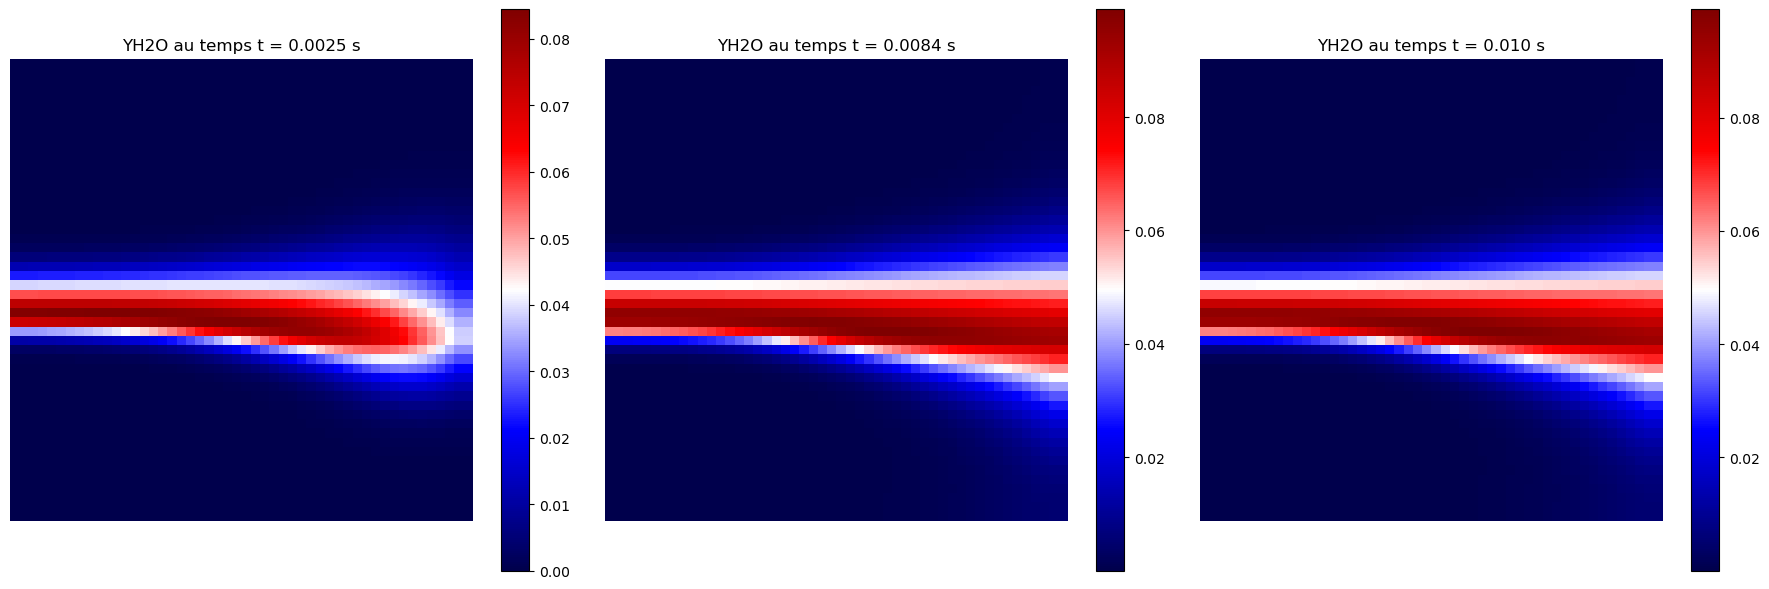

In [34]:
#Evolution de H2O avec prise en compte de la température et avec combustion = Temperature homogène à 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YH2O au temps t = {temps[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YH2O au temps t = {temps[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YH2O au temps t = {temps[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

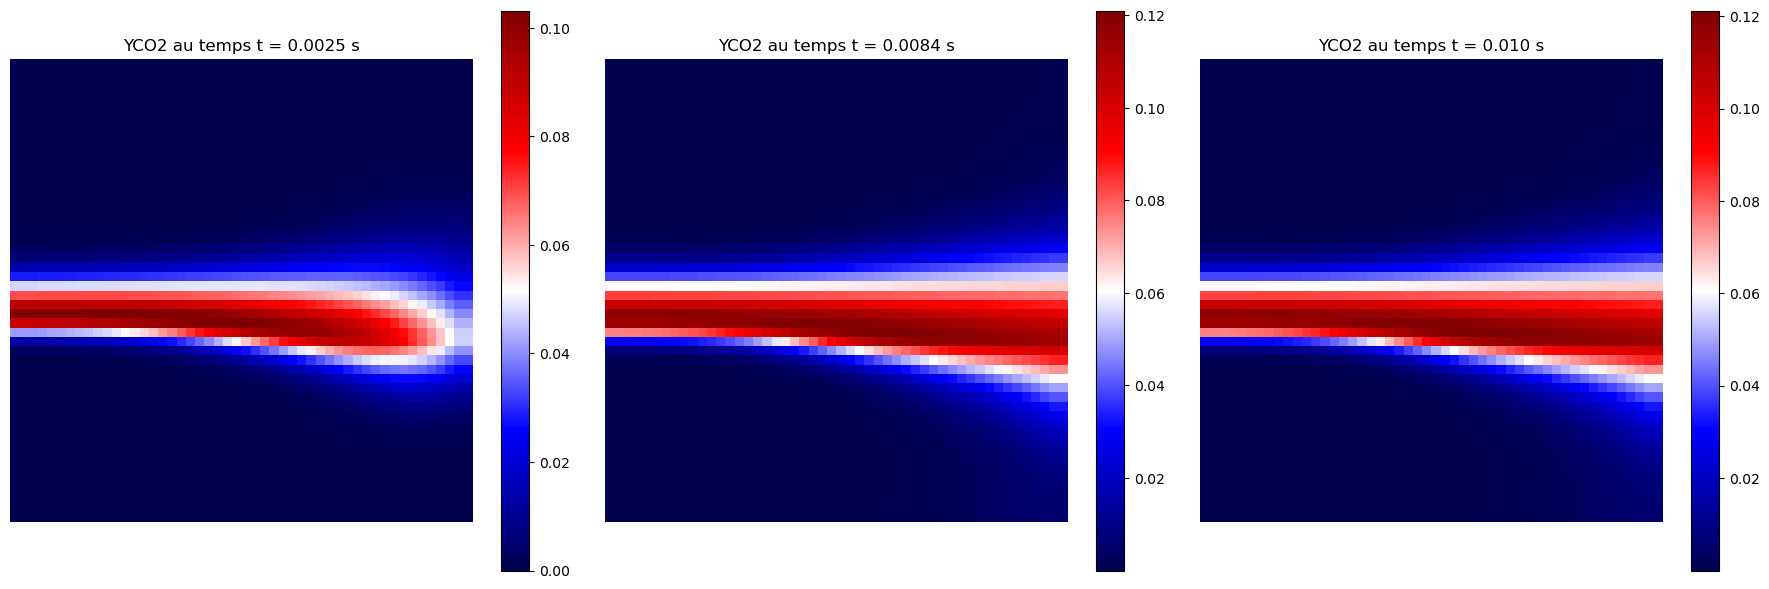

In [35]:
#Evolution de C2O avec prise en compte de la température et avec combustion = Temperature homogène à 1000K
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCO2 au temps t = {temps[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCO2 au temps t = {temps[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCO2,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCO2 au temps t = {temps[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

Avec une température homogène tout au long de la réaction, on observe une production de H2O et de CO2 qui se stabilise dans le temps. Pour le transport de CH4 et de O2, avec la prise en compte de la température, leur évolution dans le temps n'est plus du tout symétrique. C'est aux endroits ou il n'y a pas de CH4 ni de O2 que la réaction se produit et que du H2O et du CO2 sont produits. On part du principe que la flamme est stable lorsque le temps stationnaire est atteint, ce qui nous permet de passer au code du réacteur avec transport de la température. Pour cela, tant que le code tourne sur un temps inférieur au temps stationnaire, la température reste homogène comme dans le premier cas. En revanche, lorsque ce temps est dépassé, on viendra activer le transport de la température tout en continuant de résoudre les équations de transports des espèces. Cela nous mène donc au code suivant.

In [36]:
def reacteur(u,v, Nx, Tf, Nt, dt, cp, rho, D, a, Tmax, Nstat):
    #Définition des constantes 
    Ta = 10000
    A = 1.1e8
    
    #Masses molaires
    WCH4 = 16.04e-3
    WO2 = 31.99e-3
    WH2O = 18.01e-3
    WCO2 = 44.00e-3

    #Coefficients stoechiométriques
    nu_CH4 = -1
    nu_O2 = -2
    nu_H2O = 2
    nu_CO2 = 1

    #enthalpie
    HO2 = 0
    HCH4 = -74.9e3
    HH2O = -241.818e3
    HCO2 = -393.52e3

    #Determination de dtchem
    Qmax = A*(rho*0.5/WCH4)*((rho*0.1/WO2)**2)*np.exp(-10000/Tmax)
    dtchem_f = 1e3/(Qmax*10)

    if dtchem_f < dt:
        dtchem = dtchem_f
        Ntchem = int(Tf/dtchem - 1)
        print("Ntchem =", Ntchem)

    else:
        Ntchem = Nt
        dtchem = dt
        print("Ntchem =", Ntchem)
        
    ratio = int((dt // dtchem) + 1)
    dtchem = dt/(ratio)
    thydro = np.linspace(0,Tf,Nt)
    tchem = np.linspace(0,Tf,Ntchem)
    print("dthydro = ",dt)
    print("Nthydro=", Nt)
    print("ratio =", ratio)
    print("dtchem =", dtchem)
    interval = [0,(Nt-1)//4, Nstat + 4, Nt-1]
    mu = dtchem/(2*dx)
    mu2 = dtchem/dx**2
    
    #Définition des tableaux vides
    YCH4_f = np.zeros((Nx*Nx,4))
    YO2_f = np.zeros((Nx*Nx,4))
    YH2O_f = np.zeros((Nx*Nx,4))
    YCO2_f = np.zeros((Nx*Nx,4))
    T_t_f = np.zeros((Nx*Nx,4))
    t = np.zeros(4)

    #Definition des conditions initiales
    YCH40 = Yk_0(Nx, espece = "CH4")
    YO20 = Yk_0(Nx, espece = "O2")
    YH2O0 = Yk_0(Nx, espece = "H2O")
    YCO20 = Yk_0(Nx, espece = "CO2")
    T0 = T_0(Nx)
        
    #Conditions initiales 
    YCH4 = YCH40.copy()
    YO2 = YO20.copy()
    YH2O = YH2O0.copy()
    YCO2 = YCO20.copy()
    T_t = T0.copy()
    YCH4_f[:,0] = YCH40.copy()
    YO2_f[:,0] = YO20.copy()
    YH2O_f[:,0] = YH2O0.copy()
    YCO2_f[:,0] = YCO20.copy()
    T_t_f[:,0] = T0.copy()
    t[0] = 0
    
    #Tableaux pour T
    Temp_max = np.zeros((Nt))
    
    #Initialisation
    Temp_max[0] = 0
    Temperature_max = 1000
    for n in range(1,Nt):
        if n < Nstat:
            for ni in range(ratio):
                for i in range(1,Nx-1):
                    for j in range(1,Nx-1):
                        Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                        wCH4 = WCH4*nu_CH4*Q
                        wO2 = WO2*nu_O2*Q
                        wCO2 = WCO2*nu_CO2*Q
                        wH2O = WH2O*nu_H2O*Q
                
                        YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                        YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                        YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                        +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                        YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                    
                        T_t[k(i,j)] = T_t[k(i,j)] 
            #Conditions de bord
                for i in range(Nx):
                    for j in range(Nx):
                        if i == 0: #bord gauche
                            YCH4[k(i,j)] = YCH4[k(i+1,j)]
                            YO2[k(i,j)] = YO2[k(i+1,j)]
                            YH2O[k(i,j)] = YH2O[k(i+1,j)]
                            YCO2[k(i,j)] = YCO2[k(i+1,j)]
                            T_t[k(i,j)] = T_t[k(i+1,j)]
                        elif i == Nx-1: #bord droit
                            YCH4[k(i,j)] = YCH4[k(i-1,j)]
                            YO2[k(i,j)] = YO2[k(i-1,j)]
                            YH2O[k(i,j)] = YH2O[k(i-1,j)]
                            YCO2[k(i,j)] = YCO2[k(i-1,j)]
                            T_t[k(i,j)] = T_t[k(i-1,j)]
                        elif j == 0: #bord bas
                            YCH4[k(i,j)] = YCH4[k(i,j+1)]
                            YO2[k(i,j)] = YO2[k(i,j+1)]
                            YH2O[k(i,j)] = YH2O[k(i,j+1)]
                            YCO2[k(i,j)] = YCO2[k(i,j+1)]
                            T_t[k(i,j)] = T_t[k(i,j+1)]
                            if  0 <= i < Nx//4:
                                YO2[k(i,j)] = 0.21
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
                        elif j == Nx-1: #bord haut
                            YCH4[k(i,j)] = YCH4[k(i,j-1)]
                            YO2[k(i,j)] = YO2[k(i,j-1)]
                            YH2O[k(i,j)] = YH2O[k(i,j-1)]
                            YCO2[k(i,j)] = YCO2[k(i,j-1)]
                            T_t[k(i,j)] = T_t[k(i,j-1)]
                            if  0 <= i < Nx//4:
                                YCH4[k(i,j)] = 1
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
        else:
            for ni in range(ratio):
                for i in range(1,Nx-1):
                    for j in range(1,Nx-1):
                        Q = A* (rho* (YCH4[k(i,j)]/WCH4) * (rho* (YO2[k(i,j)]/WO2)**2) ) * np.exp(-Ta/T_t[k(i,j)])
                        wCH4 = WCH4*nu_CH4*Q
                        wO2 = WO2*nu_O2*Q
                        wCO2 = WCO2*nu_CO2*Q
                        wH2O = WH2O*nu_H2O*Q
                        wT = - ((HCH4/WCH4)*wCH4 + (HO2/WO2)*wO2 + (HH2O/WH2O)*wH2O + (HCO2/WCO2)*wCO2)
                        
                        YCH4[k(i,j)] = YCH4[k(i,j)] - mu * (u[k(i,j),n-1] * (YCH4[k(i+1,j)] - YCH4[k(i-1,j)]) + v[k(i,j),n-1] * (YCH4[k(i,j+1)] -YCH4[k(i,j-1)])) + mu2 * D * (YCH4[k(i+1,j)] - 4*YCH4[k(i,j)] + YCH4[k(i-1,j)] + YCH4[k(i,j+1)]  + YCH4[k(i,j-1)]) + dtchem*(1/rho)*wCH4
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCH4[k(i+1,j)] - 2*YCH4[k(i,j)] +YCH4[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCH4[k(i,j+1)] + YCH4[k(i,j-1)] - 2*YCH4[k(i,j)] )
                    
                        YO2[k(i,j)]  = YO2[k(i,j)]  - mu * (u[k(i,j),n-1] * (YO2[k(i+1,j)] - YO2[k(i-1,j)]) + v[k(i,j),n-1] * (YO2[k(i,j+1)] -YO2[k(i,j-1)])) + mu2 * D * (YO2[k(i+1,j)] - 4*YO2[k(i,j)] + YO2[k(i-1,j)] + YO2[k(i,j+1)]  + YO2[k(i,j-1)]) + dtchem*(1/rho)*wO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YO2[k(i+1,j)] - 2*YO2[k(i,j)] +YO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YO2[k(i,j+1)] + YO2[k(i,j-1)] - 2*YO2[k(i,j)] )
                    
                        YH2O[k(i,j)] = YH2O[k(i,j)] - mu * (u[k(i,j),n-1] * (YH2O[k(i+1,j)] - YH2O[k(i-1,j)]) + v[k(i,j),n-1] * (YH2O[k(i,j+1)] -YH2O[k(i,j-1)])) + mu2 * D * (YH2O[k(i+1,j)] - 4*YH2O[k(i,j)] + YH2O[k(i-1,j)] + YH2O[k(i,j+1)]  + YH2O[k(i,j-1)]) + dtchem*(1/rho)*wH2O
                        +mu2 *(u[k(i,j),n-1]**2) * ( YH2O[k(i+1,j)] - 2*YH2O[k(i,j)] +YH2O[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YH2O[k(i,j+1)] + YH2O[k(i,j-1)] - 2*YH2O[k(i,j)] )
                    
                        YCO2[k(i,j)] = YCO2[k(i,j)] - mu * (u[k(i,j),n-1] * (YCO2[k(i+1,j)] - YCO2[k(i-1,j)]) + v[k(i,j),n-1] * (YCO2[k(i,j+1)] -YCO2[k(i,j-1)])) + mu2 * D * (YCO2[k(i+1,j)] - 4*YCO2[k(i,j)] + YCO2[k(i-1,j)] + YCO2[k(i,j+1)]  + YCO2[k(i,j-1)]) + dtchem*(1/rho)*wCO2
                        +mu2 *(u[k(i,j),n-1]**2) * ( YCO2[k(i+1,j)] - 2*YCO2[k(i,j)] +YCO2[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(YCO2[k(i,j+1)] + YCO2[k(i,j-1)] - 2*YCO2[k(i,j)] )
                
                        T_t[k(i,j)] = T_t[k(i,j)]- mu * (u[k(i,j),n-1] * (T_t[k(i+1,j)] - T_t[k(i-1,j)]) + v[k(i,j),n-1] * (T_t[k(i,j+1)] - T_t[k(i,j-1)])) + mu2 * D * (T_t[k(i+1,j)] - 4*T_t[k(i,j)] + T_t[k(i-1,j)] + T_t[k(i,j+1)]  + T_t[k(i,j-1)]) + dtchem*(1/(cp*rho))*wT
                        +mu2 *(u[k(i,j),n-1]**2) * ( T_t[k(i+1,j)] - 2*T_t[k(i,j)] +T_t[k(i-1,j)]) + mu2 *(v[k(i,j),n-1]**2) *(T_t[k(i,j+1)] + T_t[k(i,j-1)] - 2*T_t[k(i,j)] )

            #Conditions de bord
                for i in range(Nx):
                    for j in range(Nx):
                        if i == 0: #bord gauche
                            YCH4[k(i,j)] = YCH4[k(i+1,j)]
                            YO2[k(i,j)] = YO2[k(i+1,j)]
                            YH2O[k(i,j)] = YH2O[k(i+1,j)]
                            YCO2[k(i,j)] = YCO2[k(i+1,j)]
                            T_t[k(i,j)] = T_t[k(i+1,j)]
                        elif i == Nx-1: #bord droit
                            YCH4[k(i,j)] = YCH4[k(i-1,j)]
                            YO2[k(i,j)] = YO2[k(i-1,j)]
                            YH2O[k(i,j)] = YH2O[k(i-1,j)]
                            YCO2[k(i,j)] = YCO2[k(i-1,j)]
                            T_t[k(i,j)] = T_t[k(i-1,j)]
                        elif j == 0: #bord bas
                            YCH4[k(i,j)] = YCH4[k(i,j+1)]
                            YO2[k(i,j)] = YO2[k(i,j+1)]
                            YH2O[k(i,j)] = YH2O[k(i,j+1)]
                            YCO2[k(i,j)] = YCO2[k(i,j+1)]
                            T_t[k(i,j)] = T_t[k(i,j+1)]
                            if  0 <= i < Nx//4:
                                YO2[k(i,j)] = 0.21
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
                        elif j == Nx-1: #bord haut
                            YCH4[k(i,j)] = YCH4[k(i,j-1)]
                            YO2[k(i,j)] = YO2[k(i,j-1)]
                            YH2O[k(i,j)] = YH2O[k(i,j-1)]
                            YCO2[k(i,j)] = YCO2[k(i,j-1)]
                            T_t[k(i,j)] = T_t[k(i,j-1)]
                            if  0 <= i < Nx//4:
                                YCH4[k(i,j)] = 1
                                T_t[k(i,j)] = 300
                            elif Nx//4 <= i < Nx//2:
                                T_t[k(i,j)] = 300
        #Ajoute la température maximale à chaque pas de temps pour comparer ensuite
        Temp_max[n] = max(Temperature_max, max(T_t))
        Temperature_max = max(T_t)
        #Permet simplement de suivre l'avancement des calculs puisque le code met beaucoup de temps à tourner
        if n%20 == 0:
            print("n=",n)
        if n in interval:
            index = interval.index(n)
            YCH4_f[:,index] = YCH4
            YO2_f[:,index] = YO2
            YH2O_f[:,index] = YH2O
            YCO2_f[:,index] = YCO2
            t[index] = n*dt
            T_t_f[:,index] = T_t
        
    return YCH4_f, YO2_f, YH2O_f, YCO2_f, T_t_f, Ntchem, t, Temp_max
YCH4_r, YO2_r, YH2O_r, YCO2_r, T_r, Ntchem_r, t_r, T_max = reacteur(u,v, Nx, Tf, Nt, dt, cp, rho, D, a, 1900, Nstat)

Ntchem = 27183
dthydro =  2.0040080160320643e-05
Nthydro= 500
ratio = 55
dtchem = 3.643650938240117e-07
n= 20
n= 40
n= 60
n= 80
n= 100
n= 120
n= 140
n= 160
n= 180
n= 200
n= 220
n= 240
n= 260
n= 280
n= 300
n= 320
n= 340
n= 360
n= 380
n= 400
n= 420
n= 440
n= 460
n= 480


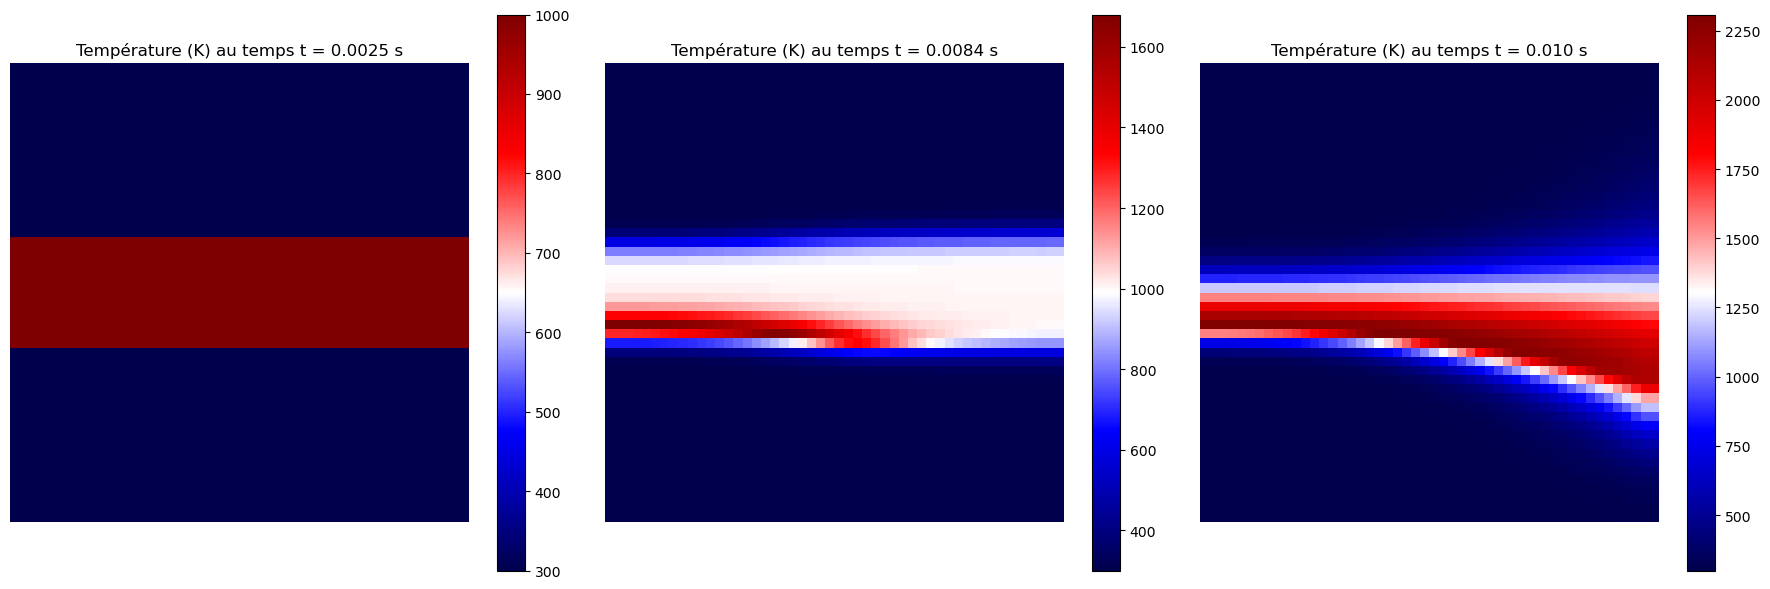

In [38]:
#Evolution de la température au cours du temps
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"Température (K) au temps t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"Température (K) au temps t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(T_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"Température (K) au temps t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

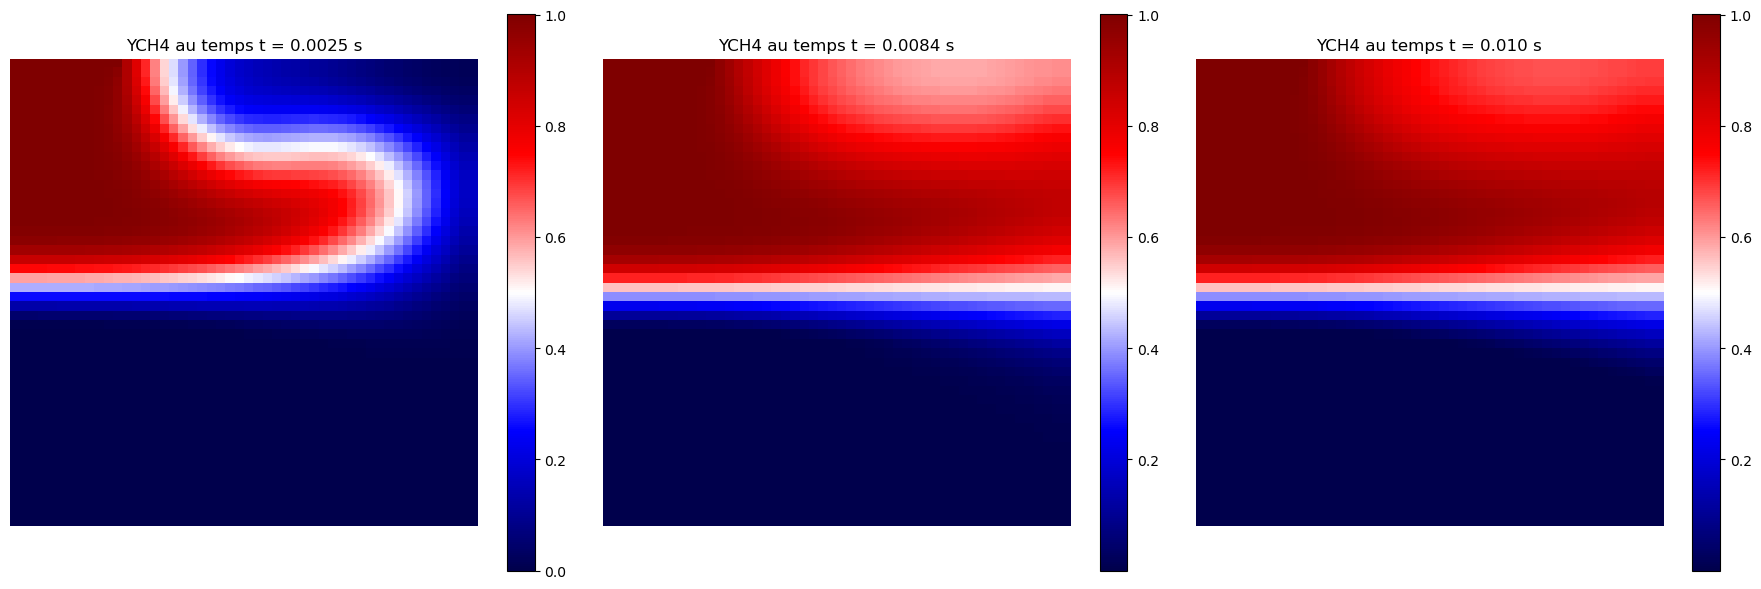

In [39]:
#Evolution de YCH4 au cours du temps
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCH4 au temps t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCH4 au temps t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YCH4_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCH4 au temps t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

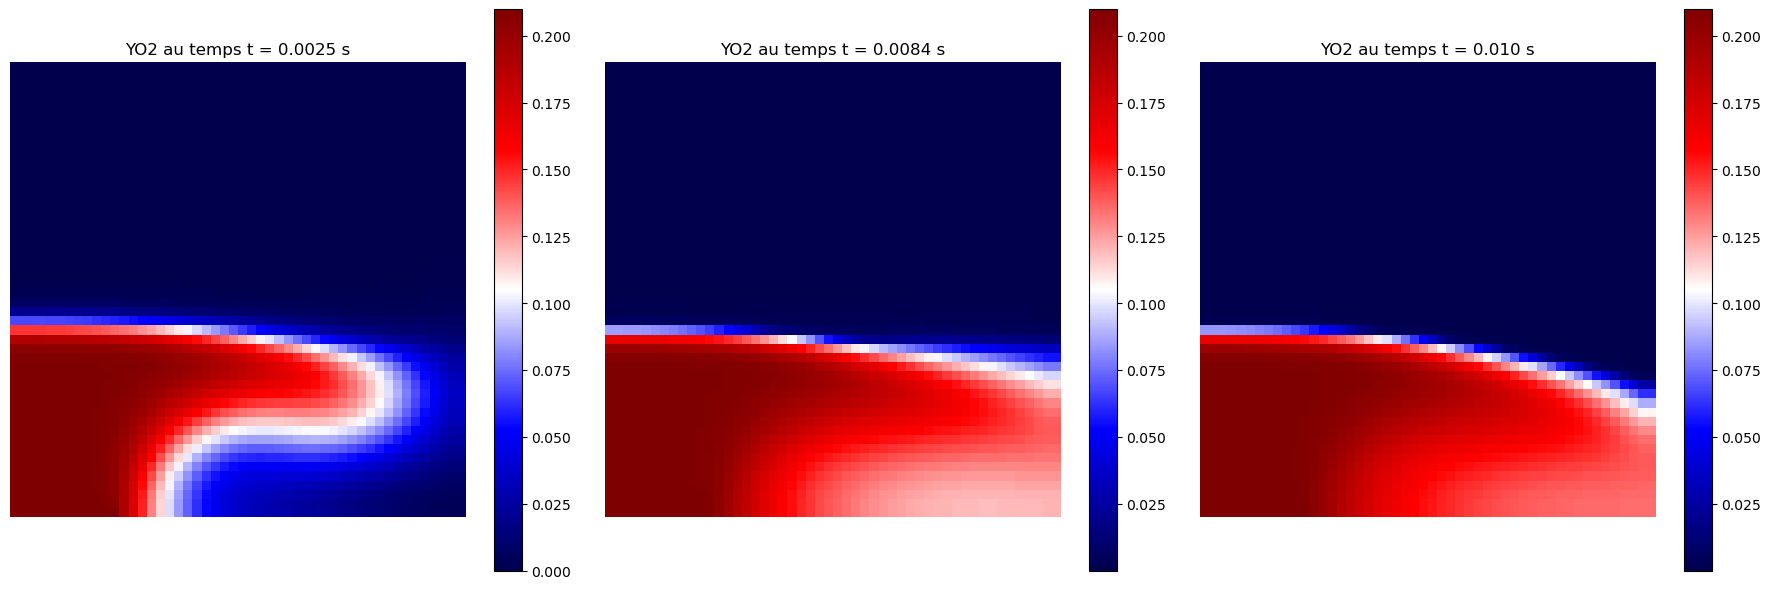

In [40]:
#Evolution de YO2 au cours du temps
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YO2 au temps t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YO2 au temps t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YO2_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YO2 au temps t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

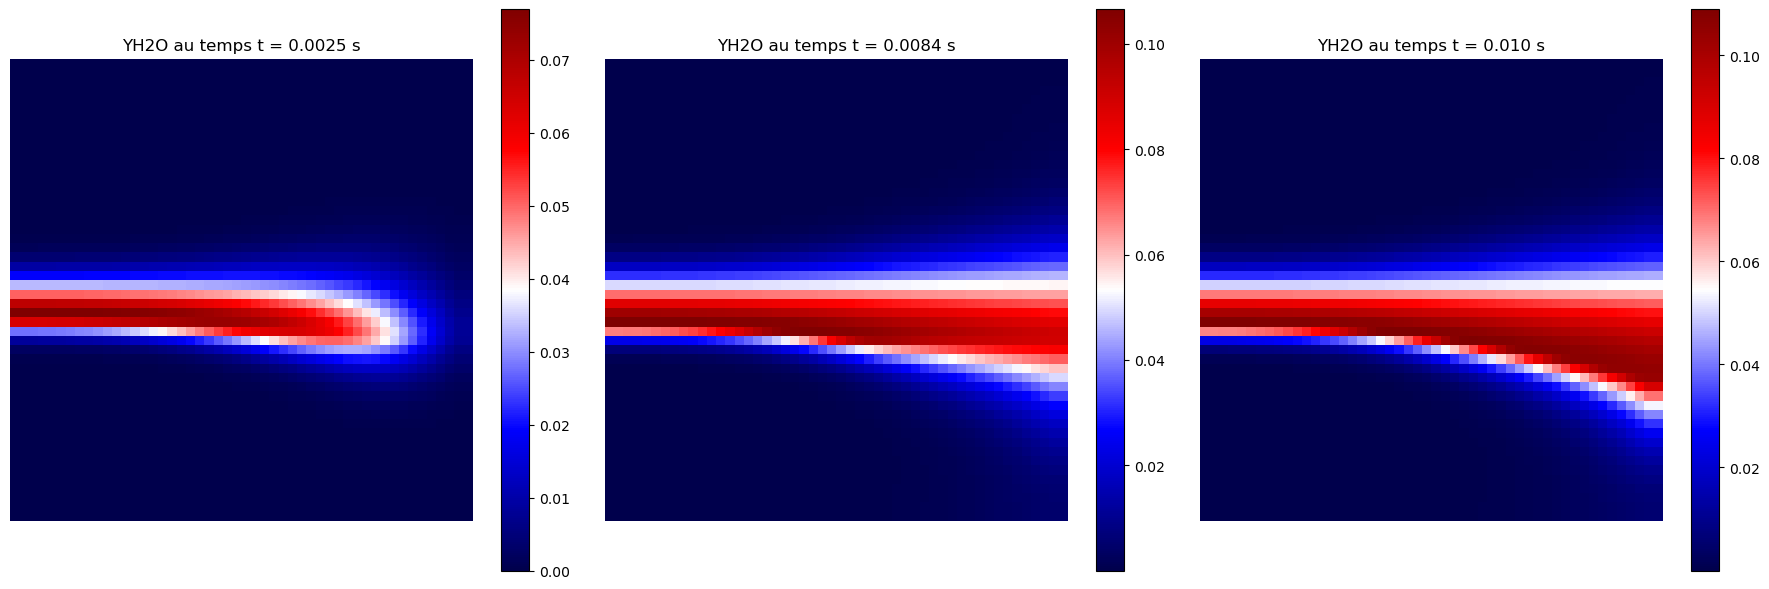

In [41]:
#Evolution de YH2O au cours du temps
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YH2O au temps t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YH2O au temps t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YH2O au temps t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

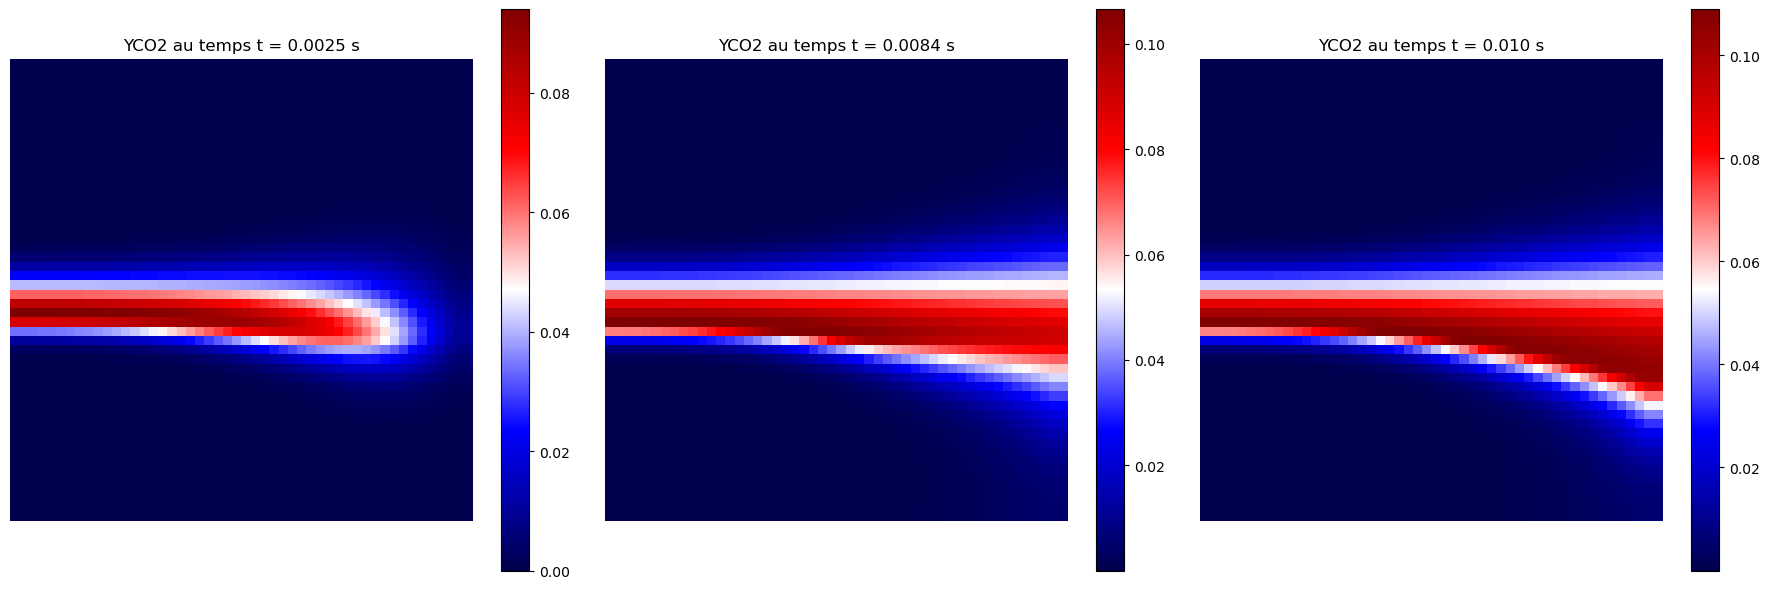

In [42]:
#Evolution de YH2O au cours du temps
fig4, axs4 = plt.subplots(1, 3, figsize=(18, 6))  # 1 ligne, 3 colonnes

im14 = axs4[0].imshow(np.reshape(YCO2_r,(Nx,Nx,4))[:,:,1], cmap='seismic')
axs4[0].set_title(f"YCO2 au temps t = {t_r[1]:.4f} s")
axs4[0].invert_yaxis()
axs4[0].axis('off')  
fig4.colorbar(im14, ax=axs4[0])

im24 = axs4[1].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,2], cmap='seismic')
axs4[1].set_title(f"YCO2 au temps t = {t_r[2]:.4f} s")
axs4[1].invert_yaxis()
axs4[1].axis('off')  
fig4.colorbar(im24, ax=axs4[1])

im34 = axs4[2].imshow(np.reshape(YH2O_r,(Nx,Nx,4))[:,:,3], cmap='seismic')
axs4[2].set_title(f"YCO2 au temps t = {t_r[3]:.3f} s")
axs4[2].invert_yaxis()
axs4[2].axis('off')  
fig4.colorbar(im34, ax=axs4[2])

plt.tight_layout()  
plt.show()

In [43]:
#Question 3 : Température max
print("La température maximale atteinte lors de la combustion est :", round(np.max(T_max),2), "°K, soit ", round(np.max(T_max) - 273.15,2),"°C")

La température maximale atteinte lors de la combustion est : 2308.2 °K, soit  2035.05 °C


Lorsqu'on commence à activer le transport de la température, on remarque que celle ci augmente là où la prodution de H2O et de CO2 est la plus forte au niveau de la bande de 1000K, c'est à dire là où la combustion est la plus forte. Au temps final, la température est distribuée de manière analogue au CO2 et au H2O, ce qui est logique car c'est là qu'est la combustion.
D'après les ressources sur internet, la température atteinte lors d'une combustion de méthane dans l'air en conditions réelles est de 1960 °C, ce qui signifie que notre valeur est légèrement supérieure. Cela peut s'explique avec plusieurs points :

- Nous sommes plutot dans les conditions idéales de combustion (la température est parfaitement homogène au début, on considère de l'air parfaitement pur, il n'y a pas de résidus quelconques), ce qui peut amener à une légère augmentation de la température simulée par rapport à la température de combustion réelle.
- Il est difficile de déterminer précisement le temps stationnaire. En effet, cela dépend de la précision choisie pour déterminer celui ci. Nous avons considéré qu'au délà d'une différence de pression de 1e-7 entre un temps t et un temps t+1 était une condition suffisante pour considérer le régime stationnaire, mais nous aurions pu aller beaucoup plus loin dans le temps, et donc dans la précision, et peut être obtenir une température légèrement plus basse que celle que nous avons. Le problème qui se pose ici est que nos machines ne sont pas assez puissantes pour aller loin dans le temps avec un tel raffinement. 

# Conclusion

Ce projet nous aura permis de nous familiariser un peu plus avec l'univers de la simulation. Lors de ce travail, plusieurs difficultés ont été rencontrées :

- La puissance de nos ordinateurs nous a empêché de pouvoir faire de gros rafinements car les temps de calculs devenaient extrêmement longs, voir impossibles. Notamment pour trouver le véritable temps stationnaire, il aurait été judicieux de pouvoir aller un peu plus loin dans le temps. Malheureusement la limite de nos machines nous en a empêché, ou bien alors il fallait tirer une croix sur la précision en espace.

- Les questions étaient parfois difficiles à comprendre et donc à coder

- Les conditions de bord étaient parfois difficiles à manier et à implémenter, notamment pour la pression dans les équations de Navier Stokes

- La détermination du $\Delta t_{chem}$ a également été difficile parce que chaque valeur un peu trop grande faisait diverger le code.

- La résolution de la pression a été la question la plus délicate car toutes les méthodes itératives testées finissaient par diverger, ou alors prenait un temps infini pour résoudre l'équation. Trouver la bonne façon de résoudre a été plutôt difficile.

Pour améliorer le travail, quelques perspectives s'offrent à nous : 

- Avec une meilleure puissance de calcul, nous pourrions aller plus loin dans le temps et avoir un raffinement de l'espace plus grand, et donc avoir peut être un meilleur résultat sur la pression.

- Avec cette puissance de calcul, nous aurions peut être pu utiliser une méthode itérative pour résoudre la pression et peut être réussir à avoir une erreur relative encore plus faible qu'avec une méthode directe de type LU.